# Setup

In [319]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [320]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import time
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
from tqdm import tqdm


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [321]:
#Stores all the images to create an animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    # writervideo = matplotlib.animation.FFMpegWriter(fps=60)
    # anim.save("video_30x30.mp4")
    plt.close()
    return anim

In [322]:
def plot_animation2(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    f = r"video1_30x30_animation.gif" 
    writergif = animation.PillowWriter(fps=30) 
    anim.save(f, writer=writergif)
    plt.close()
    return anim

# Q table and Sailboat environment

In [323]:
from numba.experimental import jitclass
from numba import njit,jit

In [324]:
###Functions###
@njit
def _get_velocity_xy(true_wind_direction , sail_direction, heading):
    u = _get_projection(true_wind_direction, sail_direction) #gets the projection in the direction of the wing
    p = u*_unitary(sail_direction) #it multiplies the projection with the unitary vector?
    diff = true_wind_direction - p #it returns the force direction that is applied from the sail
    heading_vel = _get_projection(diff, heading)*_unitary(heading)
    # we take though only the heading projection of the force
    # because of the opposite forces from the keel
    return  heading_vel

@njit
def _get_projection(v1, v2):
    return np.sum(v1*v2)/np.sqrt(np.sum(v2*v2)) # calculates the projection of v1 on v2

@njit
def _unitary(v):
    if np.sqrt(np.sum(v*v)) < 0.00001:
        return np.array([0,0],dtype=np.float64)
    return v/np.sqrt(np.sum(v*v)) #returns the unitary of v

@njit
def _get_direction(target_position, position):
    return target_position - position # direction that it should take

@njit
def _get_state(true_wind_direction, heading ,states, target_position, position):
    apparent_wind = true_wind_direction - heading
    vector = _target_vector(target_position, position)
    angle = _get_angle(apparent_wind, vector)

    return _angle_to_state(states, angle)

@njit
def _get_angle( v1, v2): # angle between 2 vectors v1 and v2
    v1 = _unitary(v1)
    v2 = _unitary(v2)
    a = np.sum(v1*v2)
    if abs(a) < 1:
        return np.arccos(a)
    return 0

@njit
def _angle_to_state(states,angle):
    if angle < 0.001: return 0
    return np.where(states < angle)[0][-1]
    #returns a tuple containing the indices where the condition is true.
    #[0] accesses the first element of the tuple, which is an array of indices satisfying the condition.
    #[-1] returns the last element of the array, which is the largest state index smaller than the given angle.

@njit
def _sample(action_space_n):
    return [np.random.randint(0, action_space_n),np.random.randint(0, int(action_space_n/4))]


@njit
def _game_over(position,target,field_size,iterations,reward,acc):
    if position[0] < field_size[0] or position[0] > field_size[1]:
        return acc, True, False
    if position[1] < field_size[0] or position[1] > field_size[1]:
        return acc, True, False
    if _distance_to_target(position,target) < 1:
        acc+=1
        # reward += 1000
        return acc, True, False
    if iterations > 100:
        return acc, True, False
    return acc, False, False


@njit
def _distance_to_target( pos, target_position):
    return np.sqrt(np.sum((target_position - pos)**2))

@njit
def _target_vector(target_position, position):
    return target_position - position

        
class SailBoat:

    def __init__(self):
        self.observation_space_n = 16  # 360//36
        self.action_space_n = 16  # 360//36
#         sda
        self.sail_angles = np.linspace(np.pi, 2*np.pi, self.action_space_n, endpoint = False)
        #in order to imagine how the sail rotate, it till go from 180 to 360 degrees
        #also it will have 16 actions based on the 16 angles of wind we can identify

        # self.helm_angles = np.linspace(np.pi+np.pi/6, 2*np.pi-np.pi/6, int(self.action_space_n/3), endpoint = True)
        self.helm_angles = np.array([211, 241., 271., 301., 331.])
        # self.helm_angles = np.array([np.pi+np.pi/6,np.pi+np.pi/4,np.pi+np.pi/3,np.pi+np.pi/2,2*np.pi-np.pi/3,2*np.pi-np.pi/4,2*np.pi-np.pi/6])

        #in order to imagine how the wing rotate, it till go from 150 to 330 degrees
        #also it will have 16 actions based on the 16 angles of wind we can identify

        #Similar to the sail angles, the state space is also discretized into 16 bins,
        #representing the possible wind directions in the environment.
        self.state_range = 2*np.pi
        self.states = np.linspace(0, self.state_range, self.observation_space_n, endpoint = False)

        self.field_size = [-30,30] #environment size
        self.time_step = 1 #the time step for decision of the boat

        self._position = np.array([-25.0, -15.0])  # starting point
        self._trajectory = [self._position]
        self._heading = np.array([0,1])  # boad heading (maybe faces north)
        self._sail_direction = np.array([-1,0])  # wing position (and maybe faces west )
        self._target_position = np.array([15,15])  # target position
        self._helm_diff = np.array([0,0])
        # self.keel_direction = np.array([0,1])
        # self.keel_direction = [self.keel_direction[0]*np.cos(np.pi/18) - self.keel_direction[1]*np.sin(np.pi/18),self.keel_direction[0]*np.sin(np.pi/18) + self.keel_direction[1]*np.cos(np.pi/18)]

        self._true_wind_direction = np.array([3,1])  # initial wind direction
        self._wind_speed = 1.0  # wind speed

        self._iterations = 1
        self._total_reward = 0

        self.position = self._position
        self.heading = self._heading
        self.sail_direction = self._sail_direction
        self.target_position = self._target_position
        self.true_wind_direction = self._true_wind_direction
        self.wind_speed = self._wind_speed
        self.velocity = self.get_velocity_xy()
        self.direction = self.get_direction()
        # self.iterations = self._iterations
        # self.helm_direction = self._helm_direction
        self.helm_turn = -self._heading
        self.helm_diff = self._helm_diff
        self.FRAMES = []
        self.acc =0


    def get_velocity_xy(self):
        return  _get_velocity_xy(self.true_wind_direction , self.sail_direction, self.heading)

    def get_projection(self, v1, v2):
        return np.inner(v1, v2)/np.linalg.norm(v2) # calculates the projection of v1 on v2

    def unitary(self, v):
        if np.linalg.norm(v) < 0.00001:
            return np.array([0,0])
        return v/np.linalg.norm(v) #returns the unitary of v


    def reset(self):
        self.iterations = self._iterations
        self.total_reward = self._total_reward

        self._position = np.array([np.random.uniform(low=-25, high=0),np.random.uniform(low=-25, high=0)]) # gives a random potision

        self.position = self._position
        self.trajectory = [self._position] #self._trajectory
        self.heading = self._heading
        self.sail_direction = self._sail_direction
        # self.helm_direction = self._helm_direction
        self.helm_turn = -self._heading
        self.helm_diff = self._helm_diff


        self._target_position = np.array([np.random.uniform(low=0, high=25),np.random.uniform(low=0, high=25)])

#         action = self.sample()
#         self._true_wind_direction = np.array([np.cos(action*self.wing_actions), np.sin(action*self.wing_actions)])

        self.target_position = self._target_position

        self.true_wind_direction = self._true_wind_direction
        self.wind_speed = self._wind_speed

        self.velocity = self.get_velocity_xy()

        self.direction = self.get_direction()
        self.state = self.get_state()
        return self.state, {'velocity': self.velocity}


    def get_direction(self):
        return _get_direction(self.target_position,self.position)


    def get_state(self):
        return _get_state(self.true_wind_direction,self.heading,self.states,self.target_position, self.position)



    def get_angle(self, v1, v2): # angle between 2 vectors v1 and v2
        return _get_angle(v1,v2)


    def angle_to_state(self, angle):
        return _angle_to_state(self.states, angle) 

    def sample(self):
        return _sample(self.action_space_n)
    
    def step(self, action):
        self.iterations += 1
        # print(action)

        # self.sail_direction = np.array([int(np.cos(self.sail_angles[action[0]])),
        #                                 int(np.sin(self.sail_angles[action[0]]))])
        start_angle = np.arctan(self.heading[1]/self.heading[0]) - np.pi/2
        # print('start',start_angle)
        # print('action',action)
        # print(self.sail_angles)
        self.sail_direction = np.array([np.cos(self.sail_angles[action[0]]+start_angle),np.sin(self.sail_angles[action[0]]+start_angle)])

        # self.helm_turn = np.array([int(np.cos(self.helm_angles[action[1]])),
        #                                 int(np.sin(self.helm_angles[action[1]]))])
        self.helm_turn = np.array([np.cos(self.helm_angles[action[1]]+start_angle),np.sin(self.helm_angles[action[1]]+start_angle)])
        self.helm_proj = self.get_projection(self.helm_turn,-self.heading)*self.unitary(-self.heading)
        self.helm_vel = np.array(self.helm_turn) - np.array(self.helm_proj)
        self.velocity = self.get_velocity_xy()
        self.move()
        reward = self.reward
        self.direction = self.get_direction()
        next_state = self.get_state()
        self.acc, done, truncated = self.game_over()
        self.total_reward += reward
        return next_state, reward, done, truncated

    def move(self):
        speed = self.get_wind_speed()
#         displacement = speed*self.velocity[1]
        new_dir = self.velocity + self.helm_vel
        displacement = speed*self.unitary(new_dir)
        self.ex_heading = self.heading
        self.heading = self.unitary(new_dir)
        ex_pos = np.linalg.norm(self.distance_to_target(self.position))
        new_pos = self.position + displacement

        self.trajectory.append(new_pos)
        self.position = new_pos
        self.reward = ex_pos - np.linalg.norm(self.distance_to_target(self.position))
        # angle = _get_angle(self.heading,self.ex_heading)
        # if angle > np.pi*50/180:
        #     self.reward -= 10


    def game_over(self):
        return _game_over(self.position,self.target_position, self.field_size, self.iterations, self.reward,self.acc)

    def distance_to_target(self, pos):
        return _distance_to_target(pos, self.target_position)

    def get_wind_speed(self):
        return self.wind_speed

    def target_vector(self):
        return _target_vector(self.target_position, self.position)


    def render(self, episode):

        fig = plt.figure(figsize=(8, 8))
        # plt.clf()
        # plt.cla()
        plt.text(-25, 26, f"{episode}, {self.iterations}, {self.total_reward:.3f}")
        plt.xlim(self.field_size)
        plt.ylim(self.field_size)
        plt.grid()

        origin = np.array([self.position]*5).T
        plt.quiver(*np.array([-25,25]).T, self.true_wind_direction[0], self.true_wind_direction[1], color = ['k'], scale = 2, scale_units = "inches", units = "inches",label = 'Wind direction')
        plt.plot(*self.target_position, "r+", markersize = 15)
        plt.scatter(*np.array(self.trajectory).T, s=10, c = "pink")
        plt.quiver(*origin, self.heading[0],self.heading[1],color = 'b',scale = 2, scale_units = "inches", units = "inches",label = 'Heading')
        plt.quiver(*origin, self.helm_turn[0],self.helm_turn[1],color = 'y',scale = 2, scale_units = "inches", units = "inches",label = 'Helm')
        plt.quiver(*origin, self.sail_direction[0],self.sail_direction[1],color = 'g',scale = 2, scale_units = "inches", units = "inches",label = 'Sail Direction')
        plt.legend()
        plt.show()
        # plt.savefig("env.png")

        # display.display(plt.gcf())
        # display.display(plt.clf())
#         display.clear_output(wait=True)

#         plt.close()

#         img = Image.fromarray("env, "RGB")
        # img = im = Image.open("env.png")
        # img = img.resize((300,300))

        # self.FRAMES.append(img)
#         time.sleep(0.05)

# Training

In [325]:
# initialize Q-table with zeros
env = SailBoat()

Q = -np.ones([env.observation_space_n,env.action_space_n,int(env.action_space_n/4)])
# q_table = np.array(q_table)
rewards = []
epsilon = 0.1  # exploration rate
epsilons = []
i_eps = 0
Q.shape

(16, 16, 4)

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\Panagiotis\AppData\Local\Temp\ipykernel_9532\1620249192.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  start_angle = np.arctan(self.heading[1]/self.heading[0]) - np.pi/2
C:\Users\Panagiotis\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'field_size' of function '_game_over'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\AppData\Local\Temp\ipykernel_9532\1620249192.py", line 56:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
  0%|                                                                     

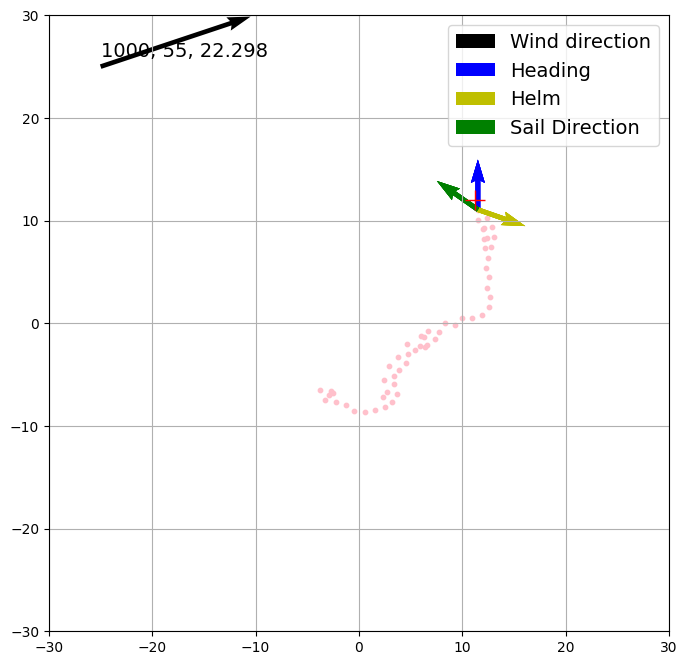

  5%|███▊                                                                         | 1003/20000 [00:45<21:13, 14.92it/s]

177


 10%|███████▋                                                                     | 1997/20000 [01:19<09:57, 30.14it/s]

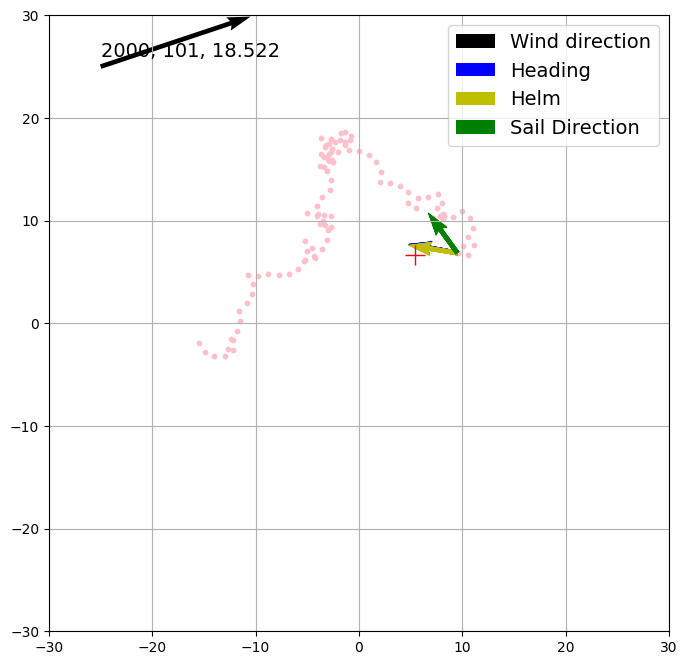

 10%|███████▋                                                                     | 2004/20000 [01:19<18:36, 16.12it/s]

347


 15%|███████████▌                                                                 | 2998/20000 [01:53<10:26, 27.15it/s]

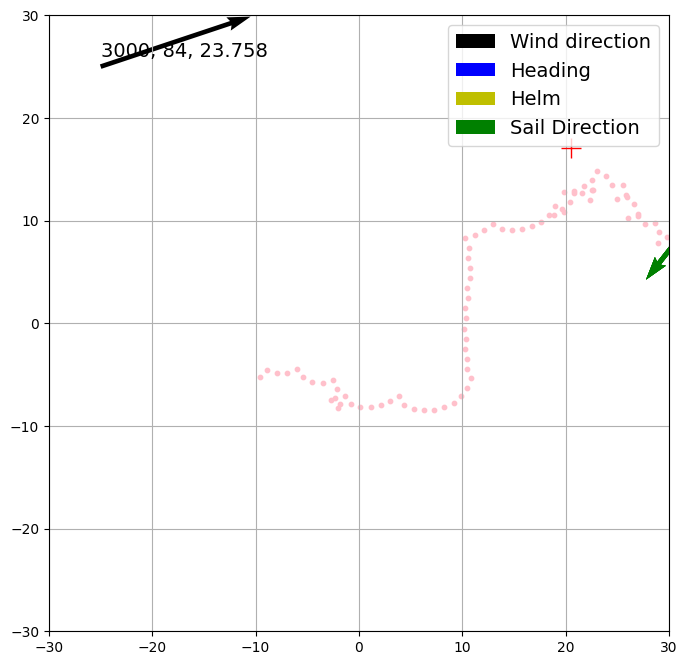

 15%|███████████▌                                                                 | 3004/20000 [01:54<17:52, 15.84it/s]

542


 20%|███████████████▍                                                             | 3996/20000 [02:27<09:33, 27.90it/s]

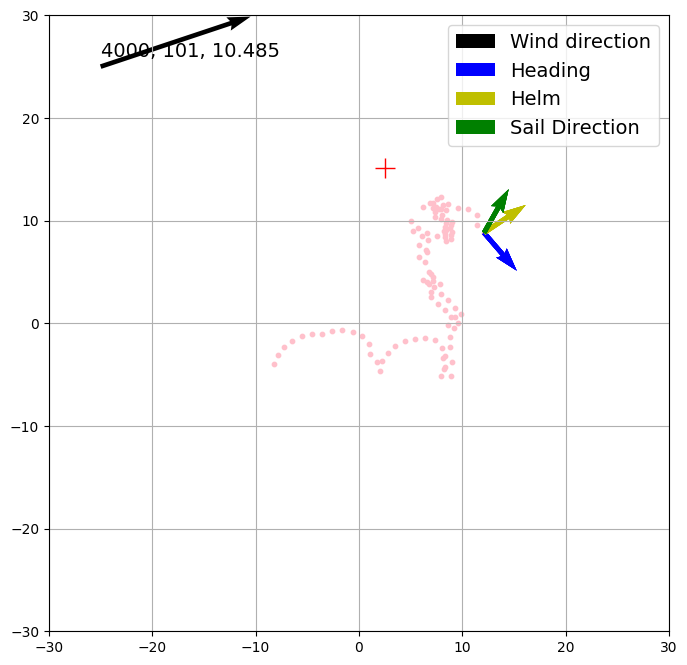

 20%|███████████████▍                                                             | 4006/20000 [02:28<14:40, 18.17it/s]

716


 25%|███████████████████▏                                                         | 4997/20000 [03:02<09:02, 27.67it/s]

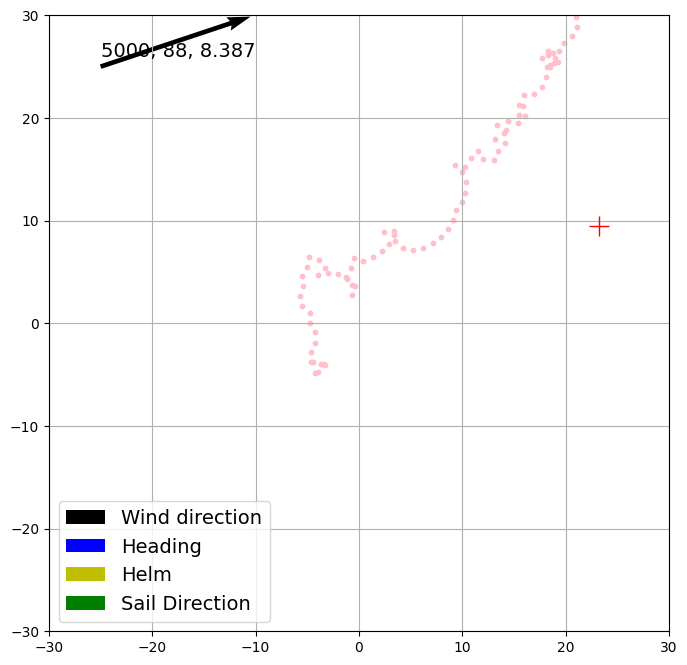

 25%|███████████████████▎                                                         | 5004/20000 [03:03<15:06, 16.54it/s]

891


 30%|███████████████████████                                                      | 5998/20000 [03:37<07:36, 30.68it/s]

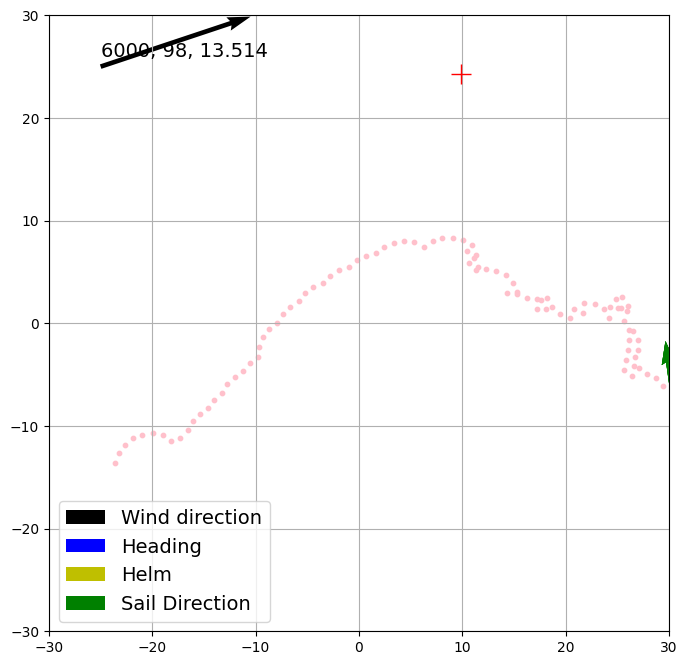

 30%|███████████████████████                                                      | 6006/20000 [03:38<13:20, 17.49it/s]

1078


 35%|██████████████████████████▉                                                  | 6998/20000 [04:12<07:02, 30.80it/s]

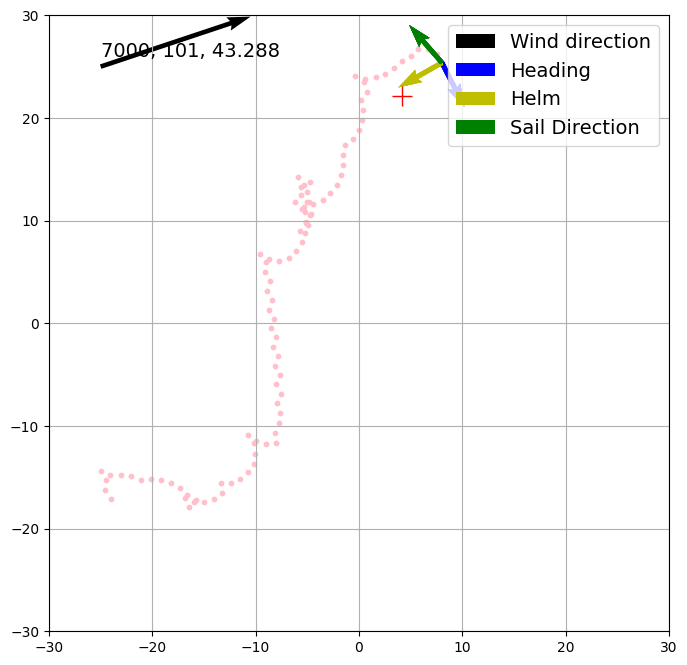

 35%|██████████████████████████▉                                                  | 7005/20000 [04:12<12:39, 17.11it/s]

1291


 40%|██████████████████████████████▊                                              | 7999/20000 [04:46<06:39, 30.06it/s]

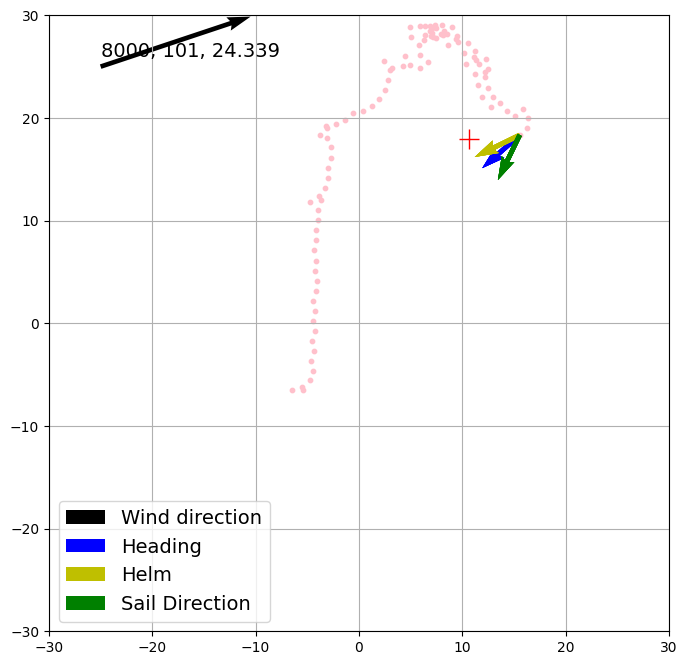

 40%|██████████████████████████████▊                                              | 8003/20000 [04:46<13:28, 14.84it/s]

1474


 45%|██████████████████████████████████▋                                          | 8997/20000 [05:20<06:05, 30.07it/s]

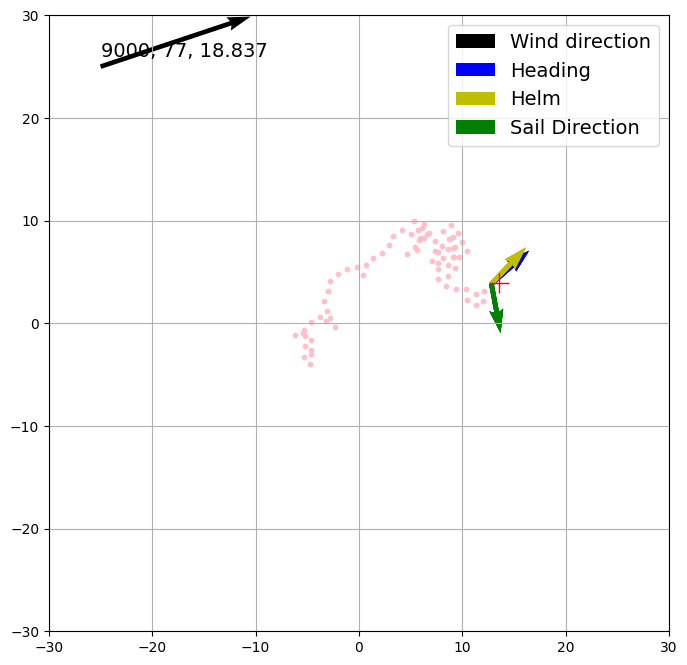

 45%|██████████████████████████████████▋                                          | 9005/20000 [05:20<10:32, 17.40it/s]

1658


 50%|██████████████████████████████████████▍                                      | 9999/20000 [05:54<05:36, 29.70it/s]

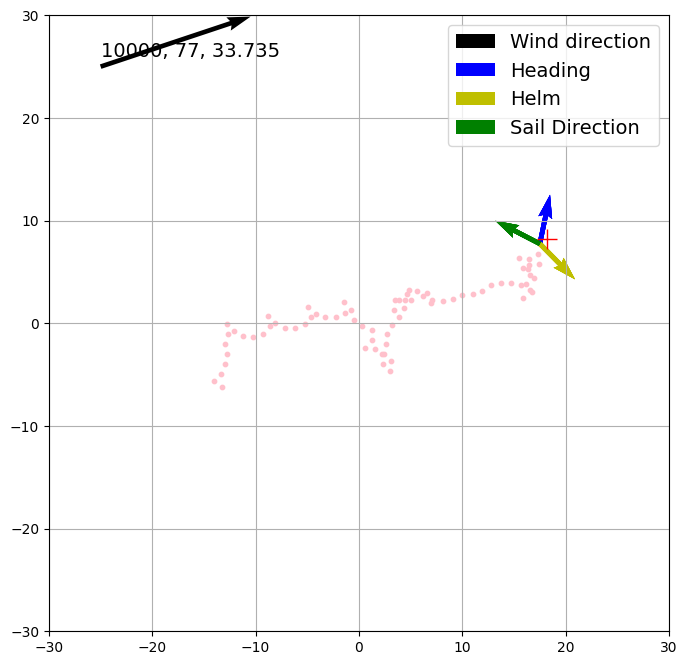

 50%|██████████████████████████████████████                                      | 10005/20000 [05:55<10:23, 16.02it/s]

1833


 55%|█████████████████████████████████████████▊                                  | 10996/20000 [06:28<05:10, 28.97it/s]

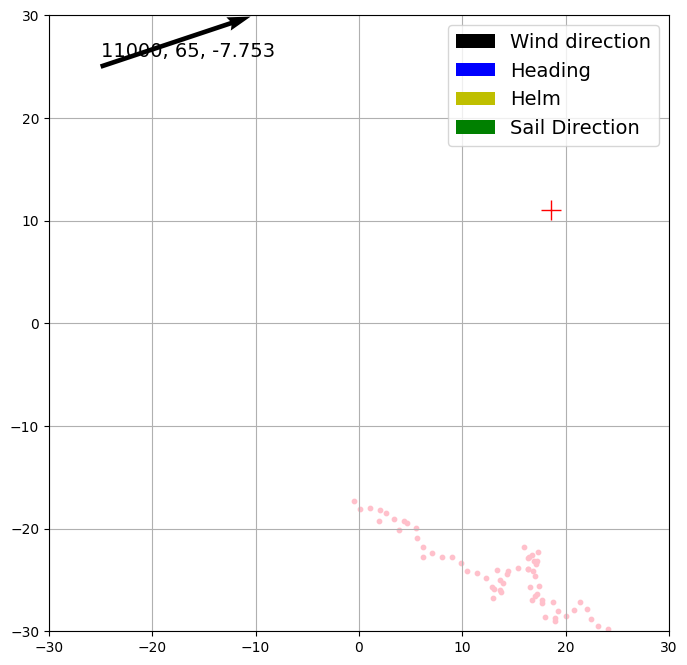

 55%|█████████████████████████████████████████▊                                  | 11003/20000 [06:28<08:49, 17.01it/s]

2007


 60%|█████████████████████████████████████████████▌                              | 11997/20000 [07:02<04:30, 29.60it/s]

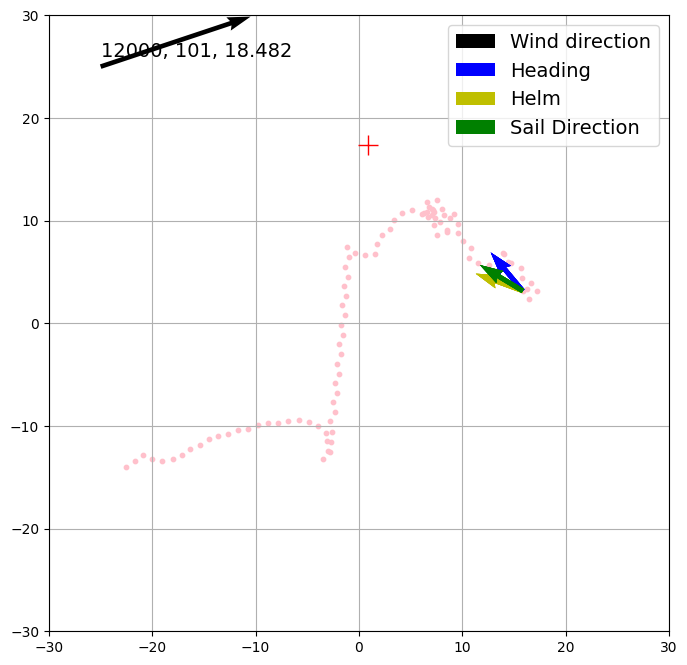

 60%|█████████████████████████████████████████████▌                              | 12006/20000 [07:03<07:08, 18.65it/s]

2194


 65%|█████████████████████████████████████████████████▍                          | 12998/20000 [07:36<03:43, 31.32it/s]

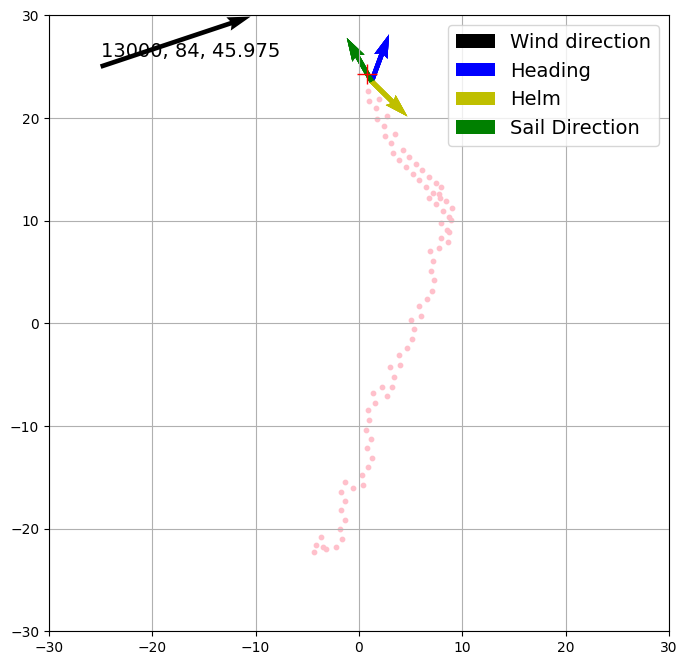

 65%|█████████████████████████████████████████████████▍                          | 13006/20000 [07:37<06:17, 18.53it/s]

2387


 70%|█████████████████████████████████████████████████████▏                      | 13997/20000 [08:10<02:59, 33.45it/s]

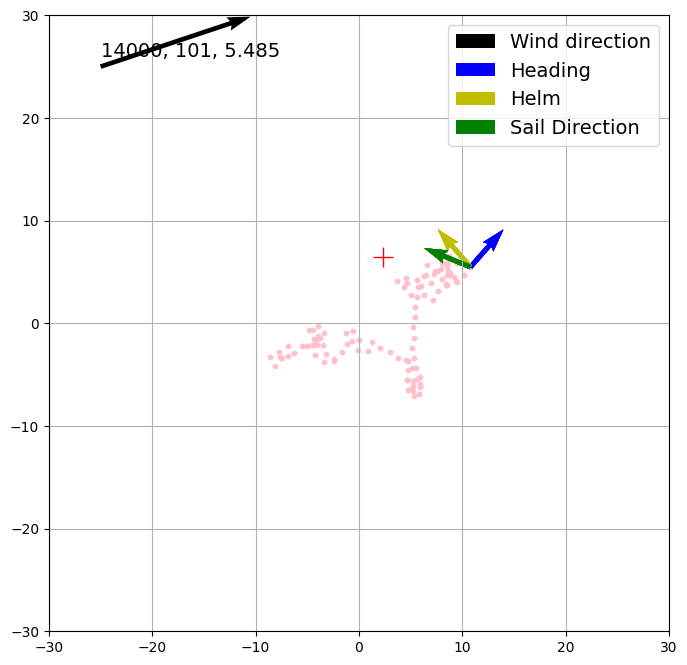

 70%|█████████████████████████████████████████████████████▏                      | 14006/20000 [08:11<05:13, 19.13it/s]

2581


 75%|████████████████████████████████████████████████████████▉                   | 14997/20000 [08:45<03:06, 26.83it/s]

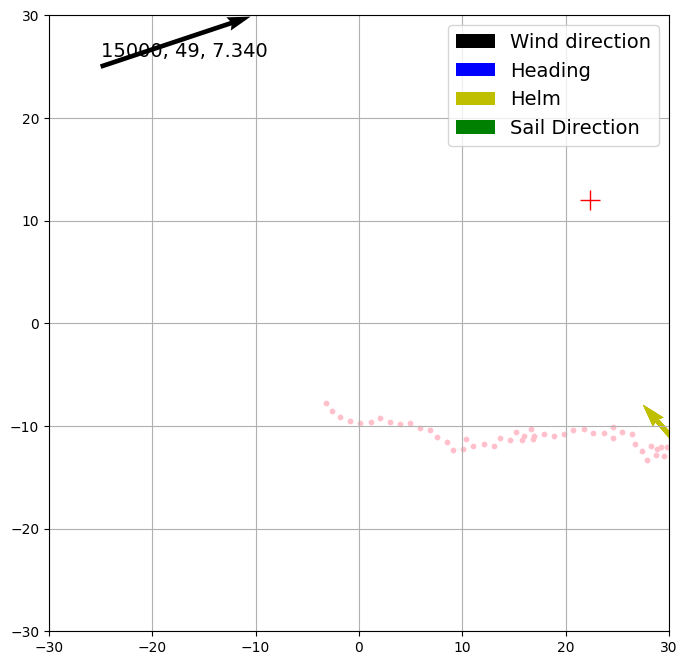

 75%|█████████████████████████████████████████████████████████                   | 15003/20000 [08:45<05:18, 15.71it/s]

2779


 80%|████████████████████████████████████████████████████████████▊               | 15998/20000 [09:20<02:13, 29.91it/s]

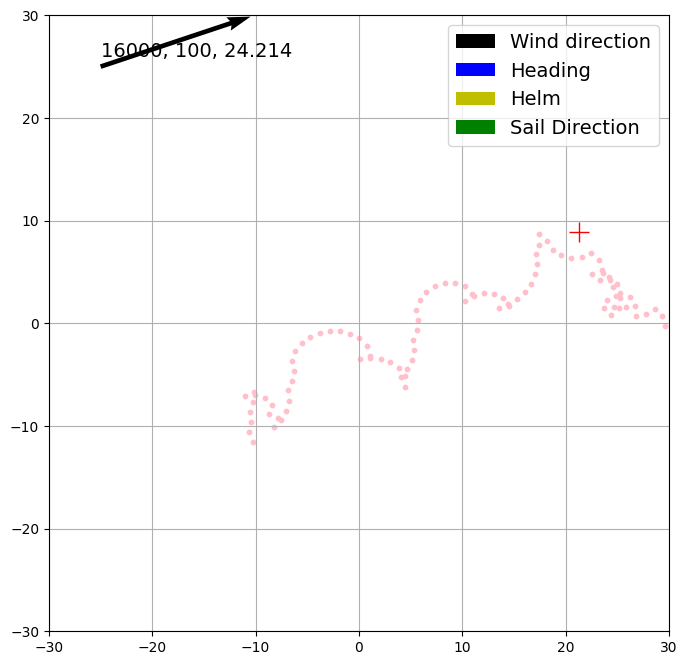

 80%|████████████████████████████████████████████████████████████▊               | 16006/20000 [09:20<03:54, 17.06it/s]

2976


 85%|████████████████████████████████████████████████████████████████▌           | 16996/20000 [09:54<01:40, 29.85it/s]

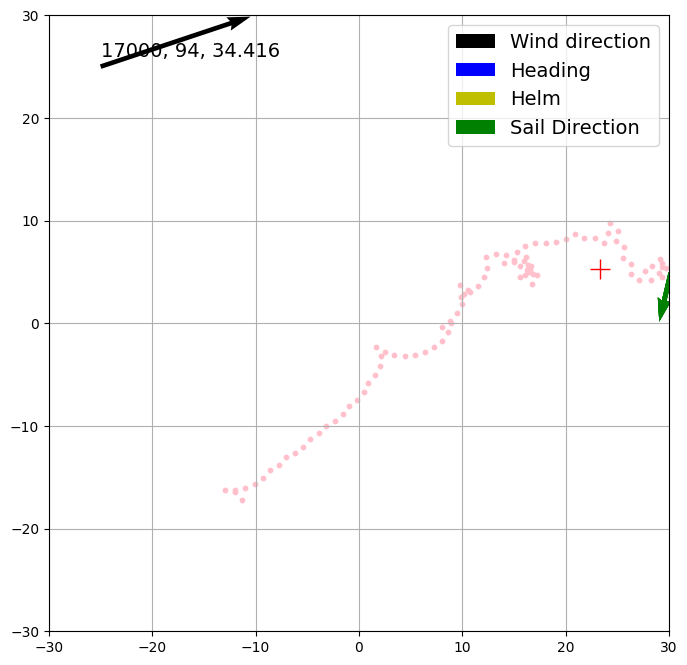

 85%|████████████████████████████████████████████████████████████████▌           | 17004/20000 [09:55<02:51, 17.52it/s]

3185


 90%|████████████████████████████████████████████████████████████████████▍       | 17996/20000 [10:29<01:05, 30.64it/s]

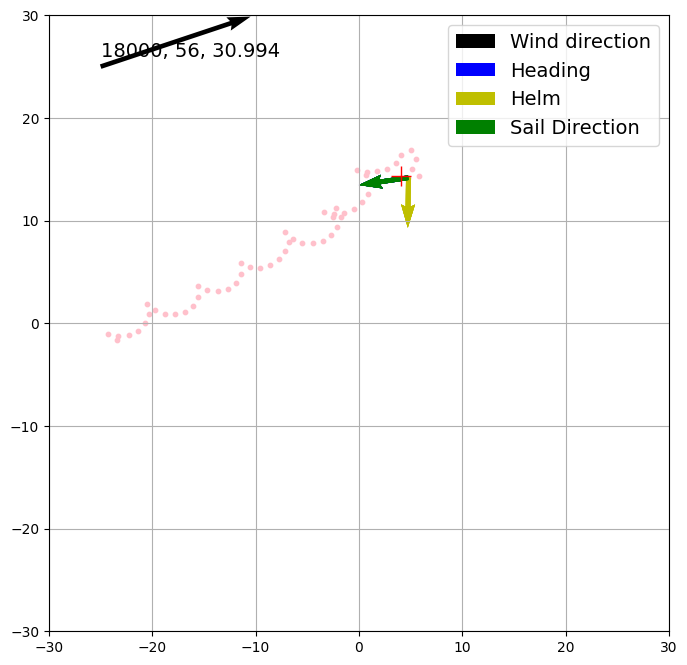

 90%|████████████████████████████████████████████████████████████████████▍       | 18003/20000 [10:29<01:55, 17.23it/s]

3365


 95%|████████████████████████████████████████████████████████████████████████▏   | 18997/20000 [11:03<00:33, 30.23it/s]

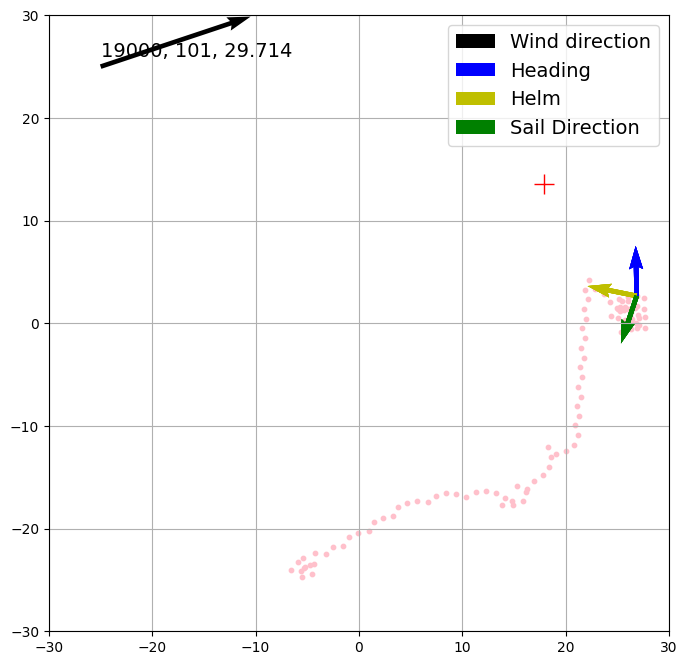

 95%|████████████████████████████████████████████████████████████████████████▏   | 19005/20000 [11:04<00:58, 17.11it/s]

3581


100%|███████████████████████████████████████████████████████████████████████████▉| 19997/20000 [11:37<00:00, 33.04it/s]

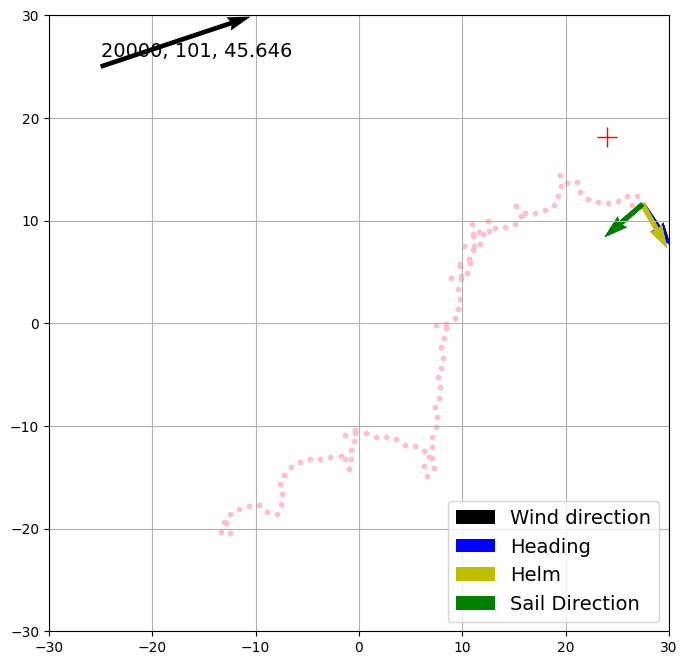

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [11:38<00:00, 28.63it/s]

3773


In [326]:
# set hyperparameters
alpha = 0.7  # learning rate
gamma = 0.95  # discount factor
accuracies = []
accs =0 
decay_epsilon = 0.999
iters = 0
# run episodes
num_episodes = 20000
# num_i_eps = 4000
animation = 1000
for i in tqdm(range(1, num_episodes + 1)):
    # epsilons.append(epsilon)
    state, info = env.reset()
    done = False
    while not done:
        # choose action using epsilon-greedy policy
        # if i_eps < num_i_eps:
        #     action = env.sample()
        if np.random.uniform(0, 1) < epsilon:
            action = env.sample()
            # print(1,action)
        else:
            action = np.unravel_index(np.argmax((Q[state, :])), (Q[state, :]).shape)
            # print(Q[state, :])
            # action = np.array([action[0],action[1]])
            # print(2,*action)
        # take action and observe next state and reward
        # for redo in range(5):
        next_state, reward, done, truncated = env.step(action) #state_action(state, action)

        # update Q-table
        Q[state, *action] += alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, *action])
        # update state
        state = next_state
        # if i_eps >= num_i_eps:
        #     if epsilon > 0.1:
        #         epsilon *= decay_epsilon    
    if i%animation == 0: 
        env.render(i)
        accuracies.append(env.acc)

        print(env.acc)
        
    # i_eps += 1
    rewards.append(env.total_reward/env.iterations)
#     Q /= np.max(Q)

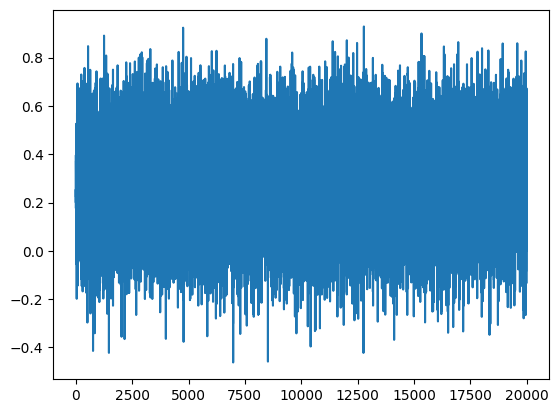

In [327]:
x = np.arange(0,len(rewards))
plt.plot(x,rewards)

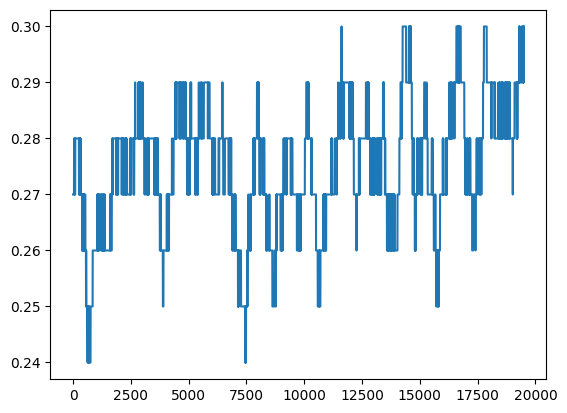

In [328]:
# Program to calculate moving average using numpy
  
import numpy as np
  
arr = rewards
window_size = 500
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
  
# Loop through the array t o
#consider every window of size 3
while i < len(arr) - window_size + 1:
  
    # Calculate the average of current window
    window_average = round(np.sum(arr[
      i:i+window_size]) / window_size, 2)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

x2 = np.arange(0,len(moving_averages))
plt.plot(x2,moving_averages)

In [329]:
env.acc

3773

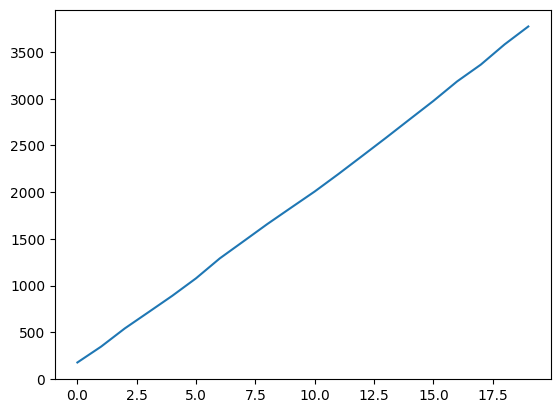

In [330]:
plt.plot(accuracies)

# Test

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\Panagiotis\AppData\Local\Temp\ipykernel_9532\1620249192.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  start_angle = np.arctan(self.heading[1]/self.heading[0]) - np.pi/2
  1%|▊                                                                                 | 5/500 [00:00<00:10, 45.04it/s]

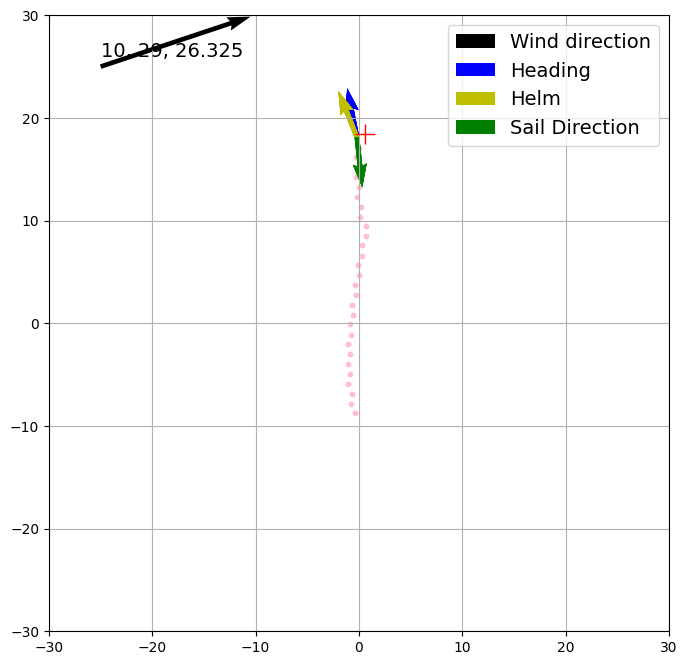

  3%|██▌                                                                              | 16/500 [00:00<00:24, 19.86it/s]

6


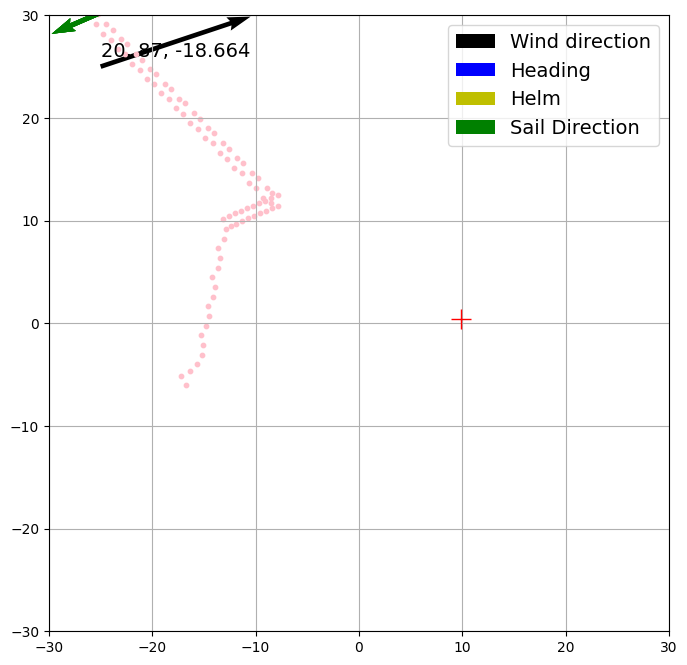

  5%|███▉                                                                             | 24/500 [00:01<00:29, 16.16it/s]

10


  6%|████▌                                                                            | 28/500 [00:01<00:24, 19.13it/s]

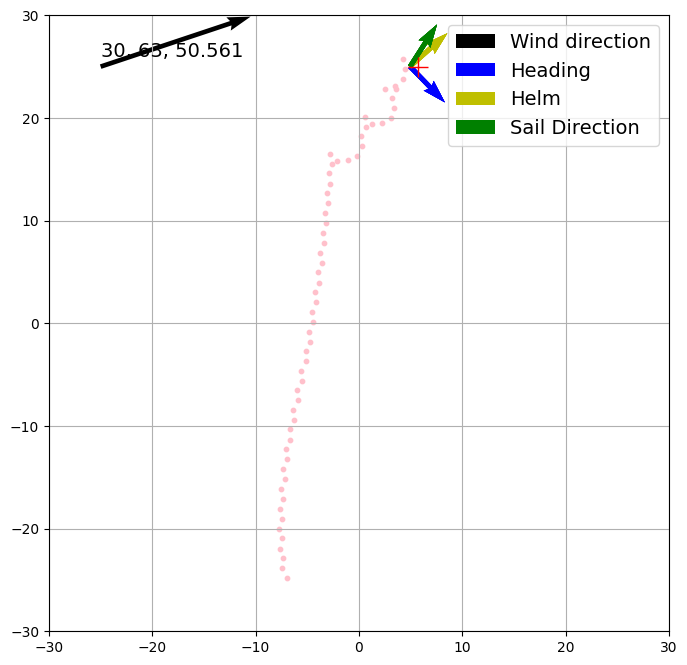

  7%|█████▊                                                                           | 36/500 [00:02<00:27, 16.65it/s]

14


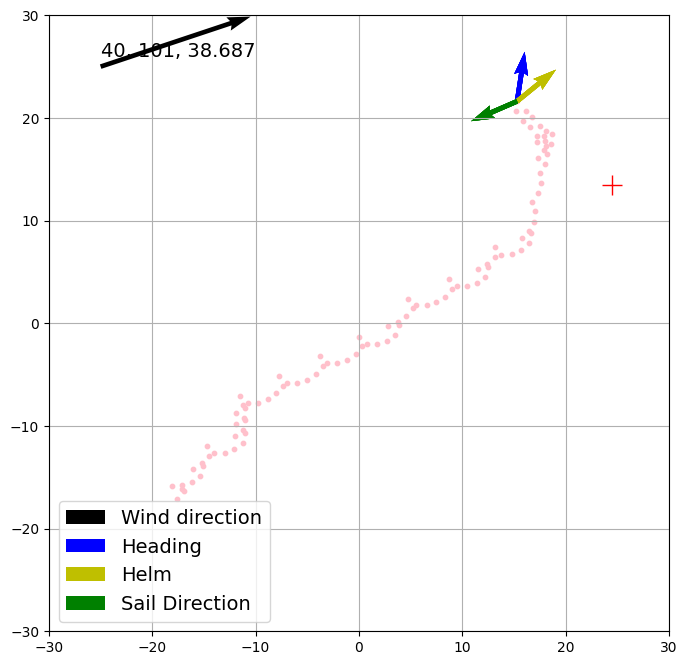

  9%|███████▎                                                                         | 45/500 [00:02<00:28, 16.10it/s]

19


 10%|███████▉                                                                         | 49/500 [00:03<00:23, 18.98it/s]

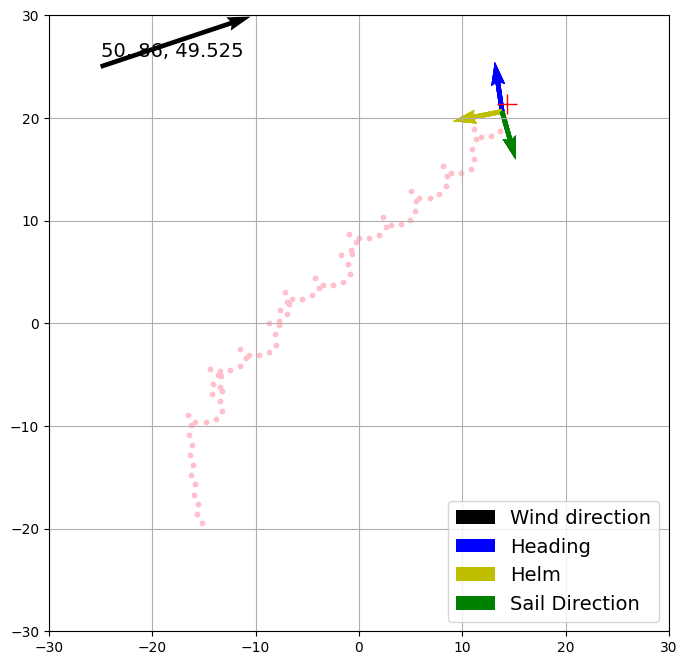

 12%|█████████▍                                                                       | 58/500 [00:03<00:26, 16.38it/s]

24


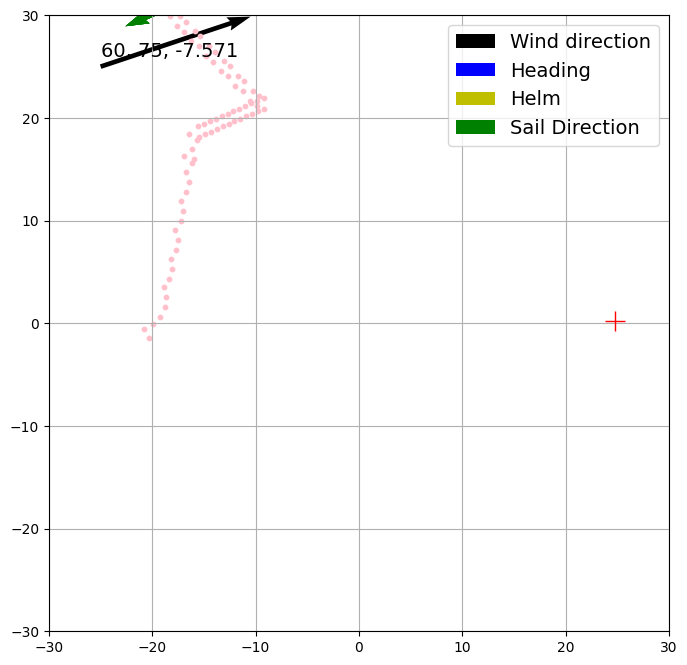

 13%|██████████▌                                                                      | 65/500 [00:04<00:29, 14.68it/s]

27


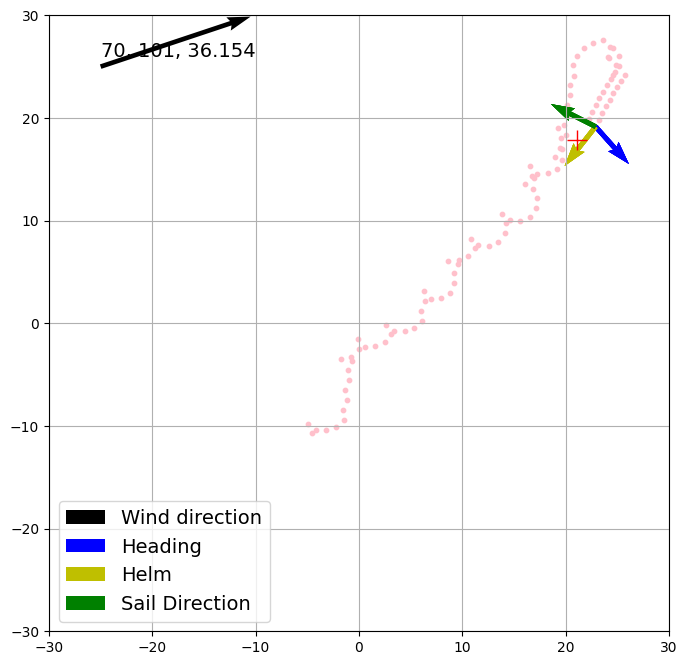

 15%|███████████▉                                                                     | 74/500 [00:05<00:29, 14.63it/s]

31


 16%|████████████▊                                                                    | 79/500 [00:05<00:23, 18.20it/s]

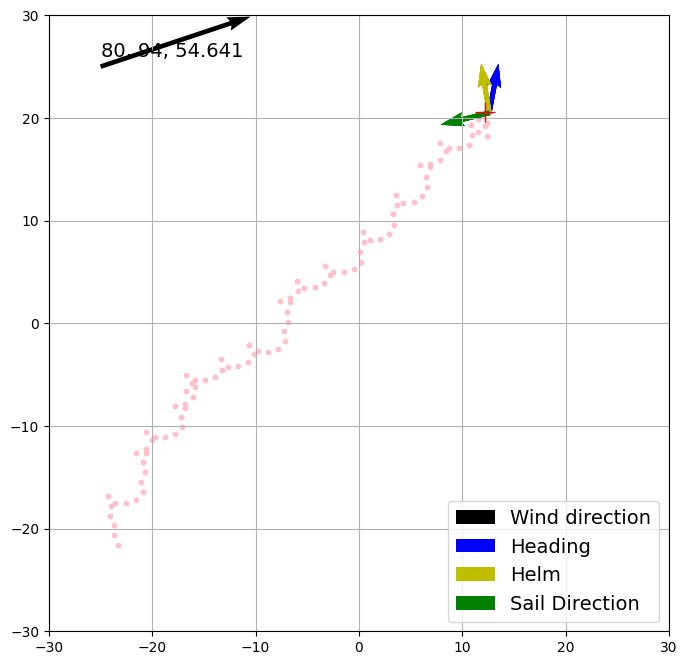

 17%|█████████████▉                                                                   | 86/500 [00:05<00:27, 14.99it/s]

33


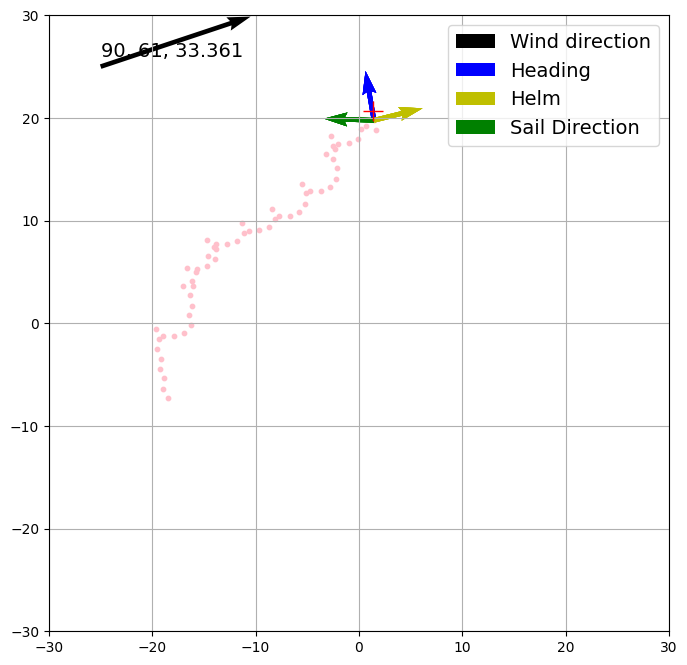

 19%|███████████████▏                                                                 | 94/500 [00:06<00:27, 14.59it/s]

39


 20%|████████████████                                                                 | 99/500 [00:06<00:21, 19.01it/s]

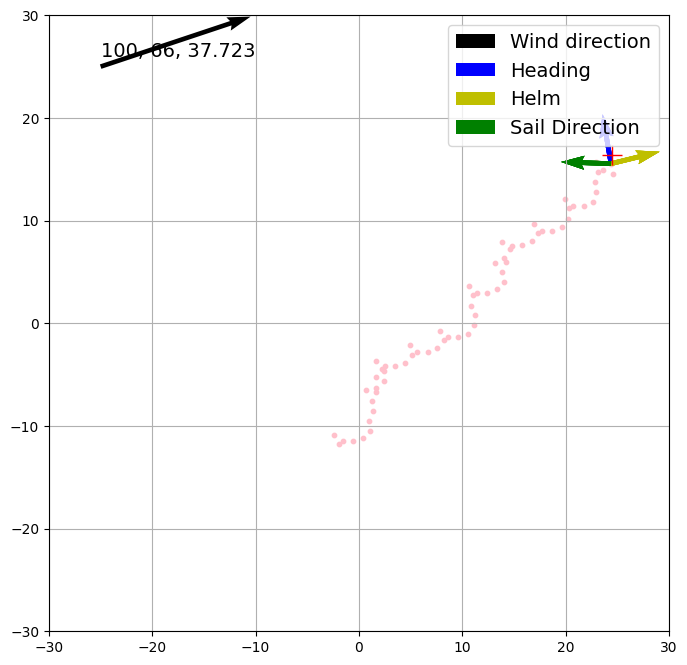

 22%|█████████████████▎                                                              | 108/500 [00:07<00:22, 17.27it/s]

45


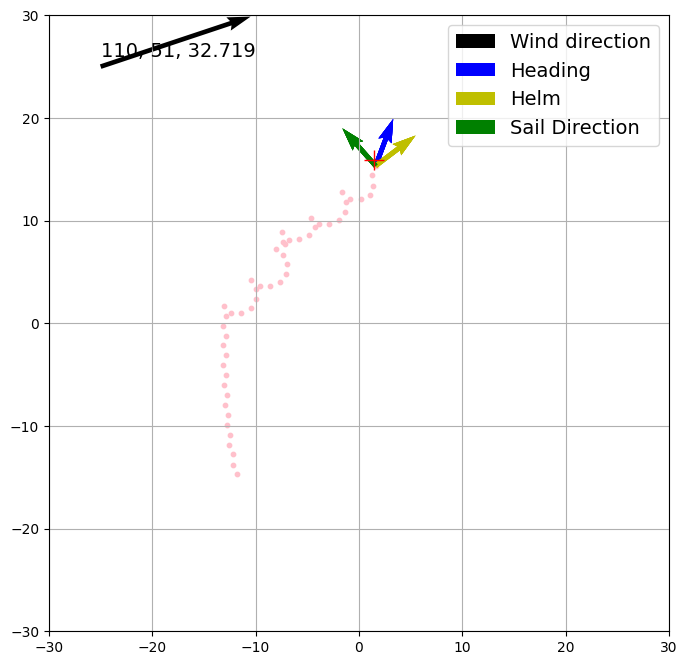

 23%|██████████████████▍                                                             | 115/500 [00:07<00:25, 14.84it/s]

49


 24%|███████████████████                                                             | 119/500 [00:07<00:21, 18.11it/s]

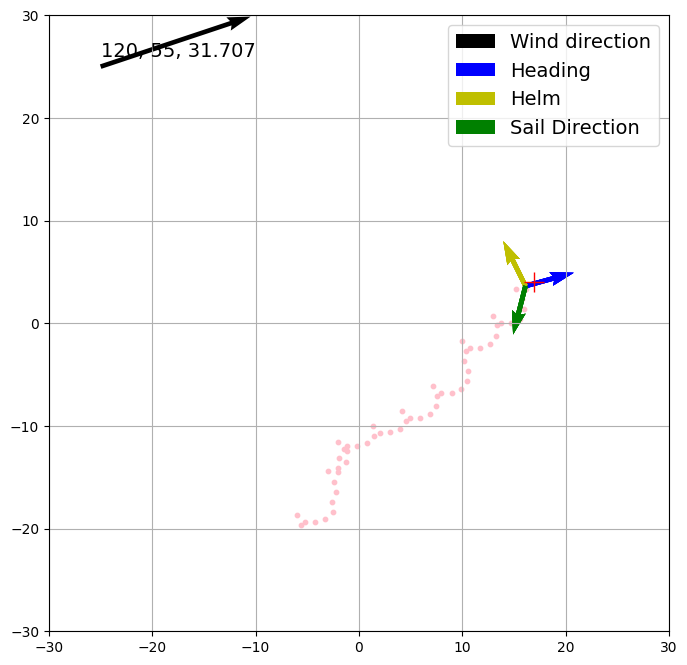

 25%|████████████████████▎                                                           | 127/500 [00:08<00:23, 15.64it/s]

51


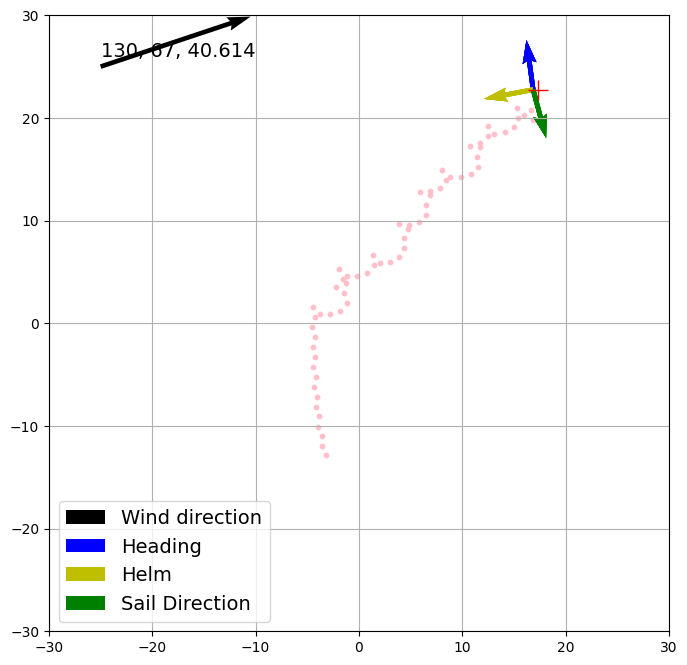

 27%|█████████████████████▌                                                          | 135/500 [00:09<00:23, 15.57it/s]

56


 28%|██████████████████████▏                                                         | 139/500 [00:09<00:20, 17.94it/s]

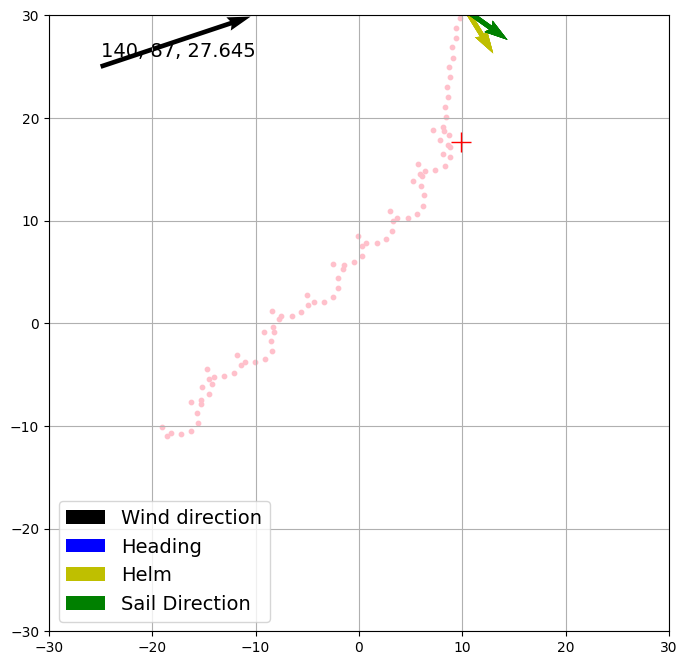

 29%|███████████████████████▌                                                        | 147/500 [00:10<00:22, 16.00it/s]

60


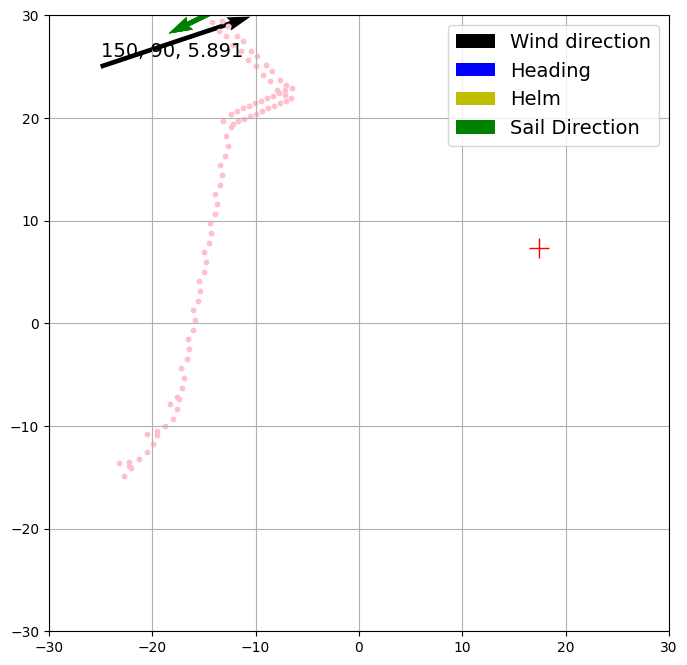

 31%|████████████████████████▋                                                       | 154/500 [00:10<00:24, 14.37it/s]

65


 32%|█████████████████████████▍                                                      | 159/500 [00:10<00:17, 19.15it/s]

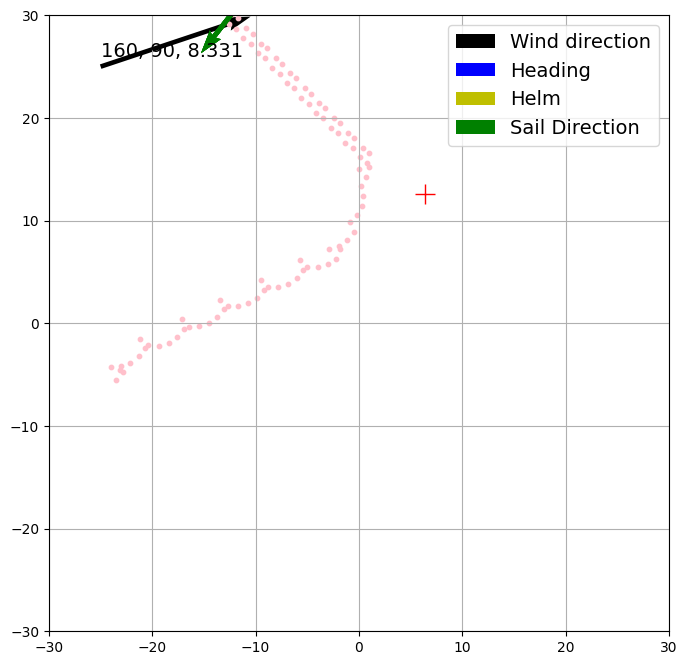

 34%|██████████████████████████▉                                                     | 168/500 [00:11<00:20, 16.34it/s]

72


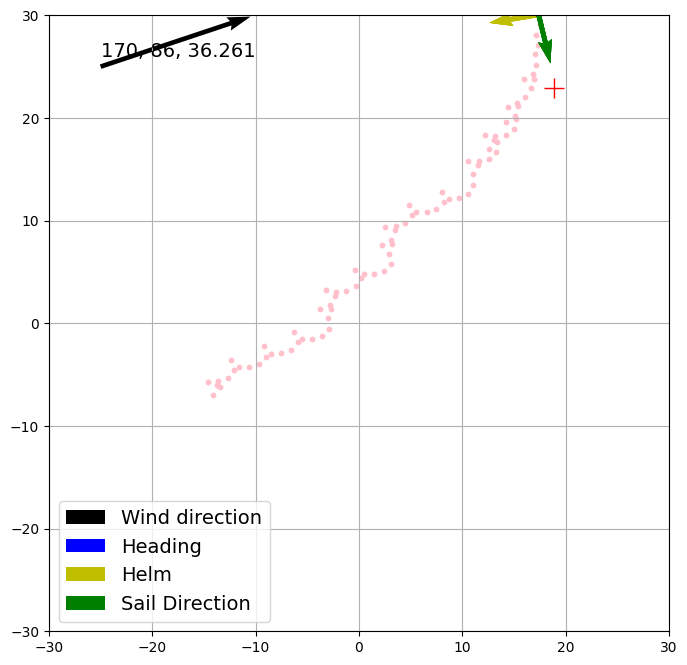

 35%|████████████████████████████                                                    | 175/500 [00:12<00:23, 14.11it/s]

76


 36%|████████████████████████████▋                                                   | 179/500 [00:12<00:18, 17.41it/s]

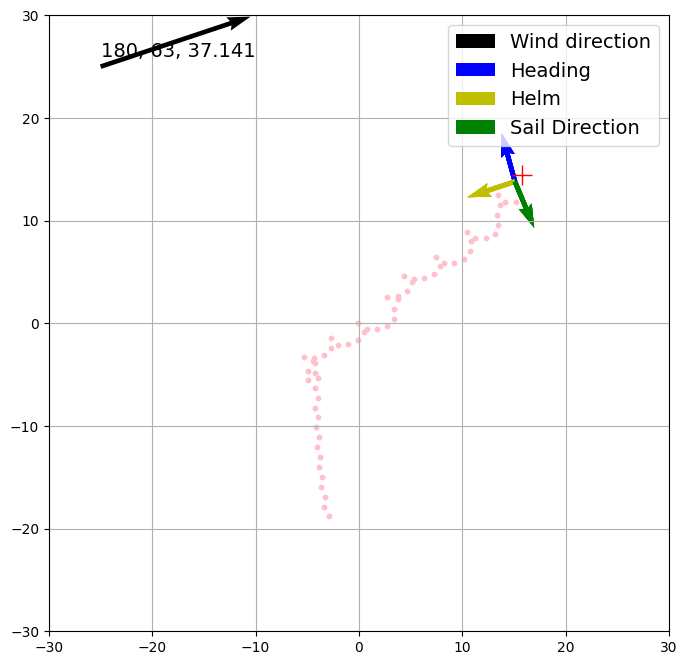

 37%|█████████████████████████████▌                                                  | 185/500 [00:12<00:23, 13.25it/s]

80


 38%|██████████████████████████████▏                                                 | 189/500 [00:13<00:18, 16.86it/s]

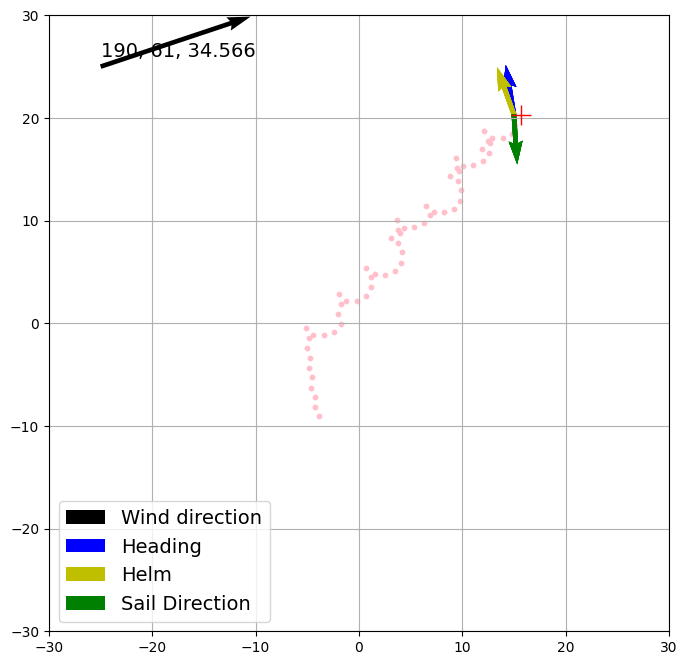

 39%|███████████████████████████████▎                                                | 196/500 [00:13<00:21, 14.32it/s]

85


 40%|███████████████████████████████▊                                                | 199/500 [00:13<00:18, 16.24it/s]

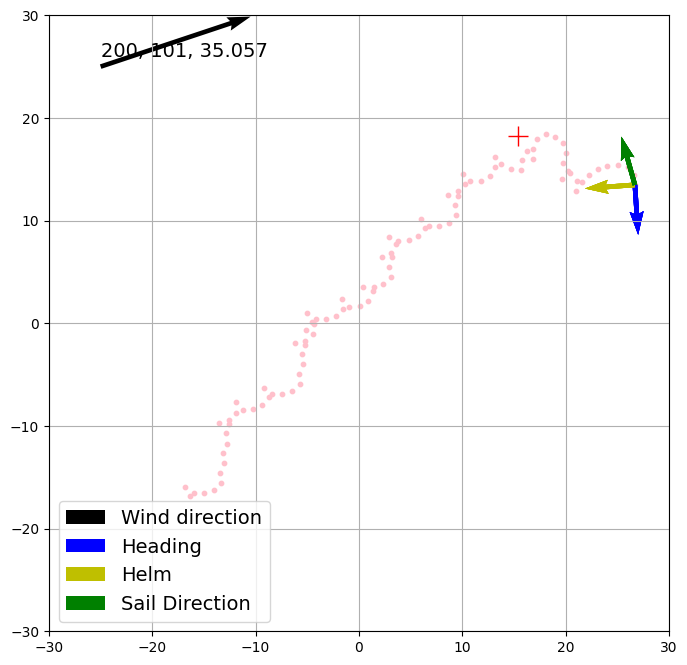

 41%|████████████████████████████████▉                                               | 206/500 [00:14<00:20, 14.09it/s]

88


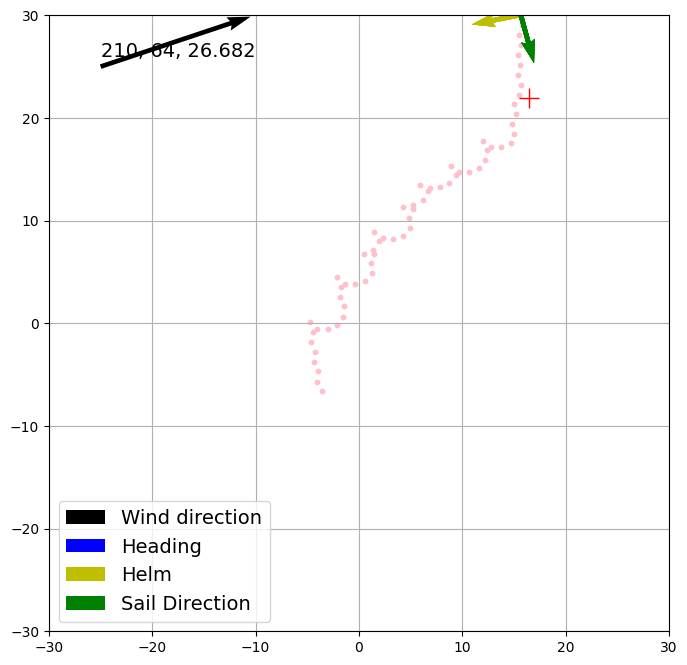

 43%|██████████████████████████████████▏                                             | 214/500 [00:15<00:20, 14.00it/s]

93


 44%|███████████████████████████████████                                             | 219/500 [00:15<00:14, 18.78it/s]

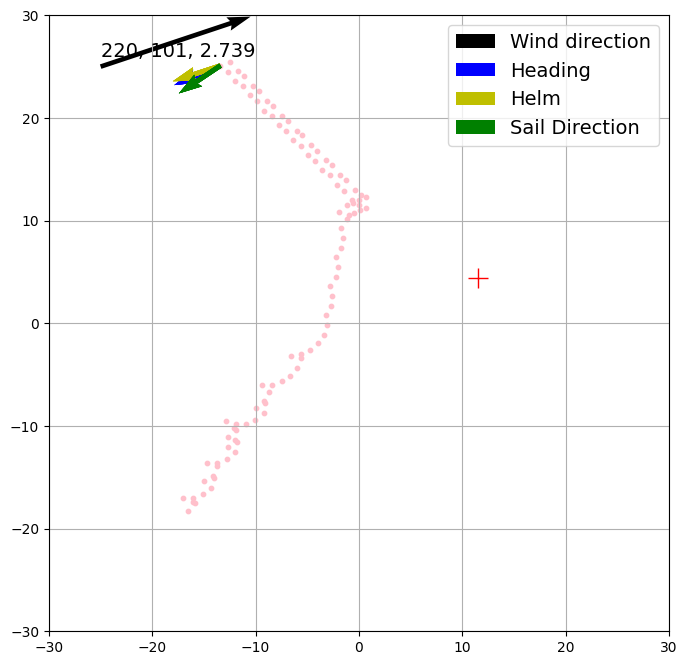

 46%|████████████████████████████████████▍                                           | 228/500 [00:15<00:16, 16.41it/s]

97


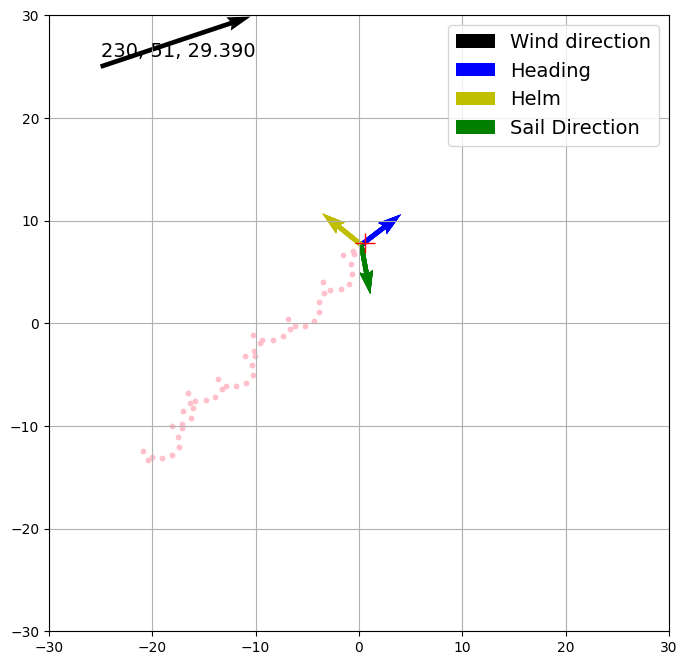

 47%|█████████████████████████████████████▊                                          | 236/500 [00:16<00:16, 15.73it/s]

103


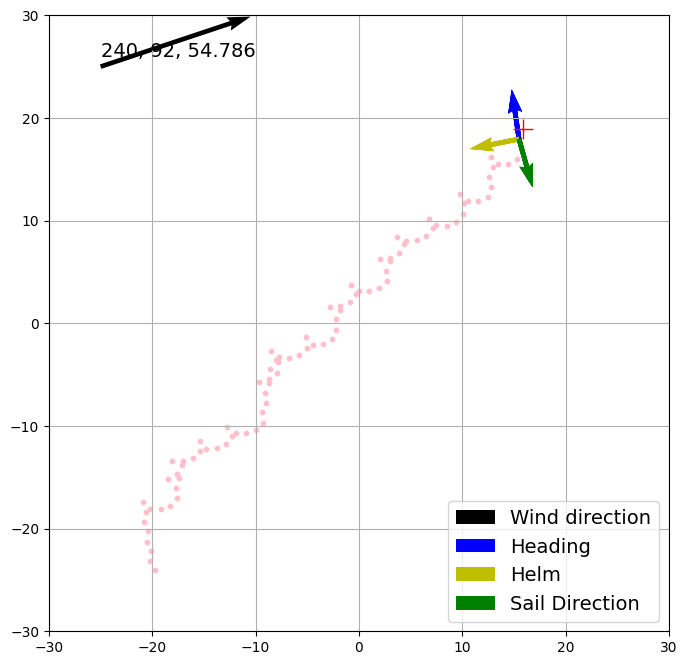

 49%|███████████████████████████████████████▎                                        | 246/500 [00:17<00:16, 15.37it/s]

108


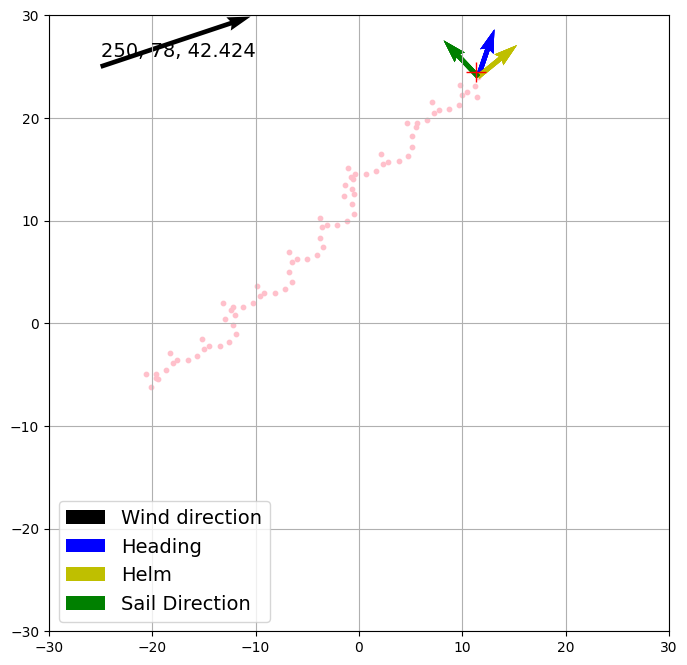

 51%|████████████████████████████████████████▉                                       | 256/500 [00:17<00:14, 16.46it/s]

111


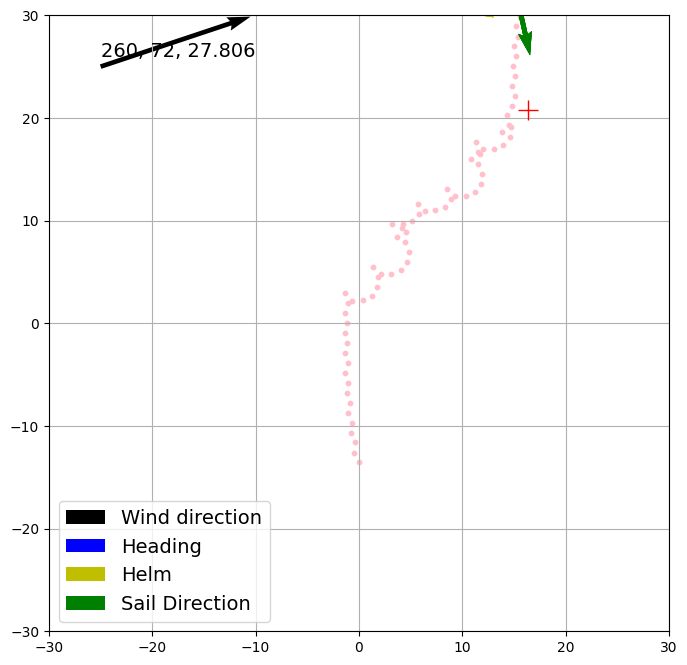

 53%|██████████████████████████████████████████▌                                     | 266/500 [00:18<00:13, 17.09it/s]

117


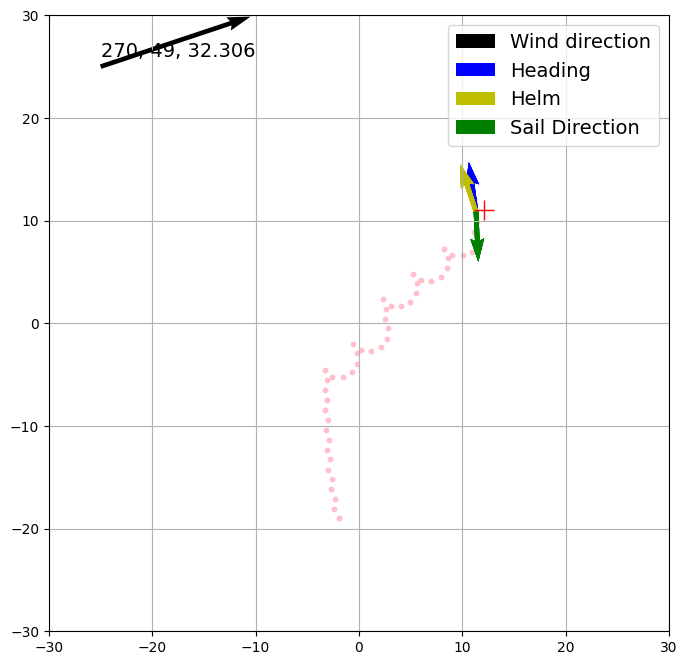

 55%|███████████████████████████████████████████▊                                    | 274/500 [00:19<00:14, 15.63it/s]

124


 56%|████████████████████████████████████████████▋                                   | 279/500 [00:19<00:11, 19.50it/s]

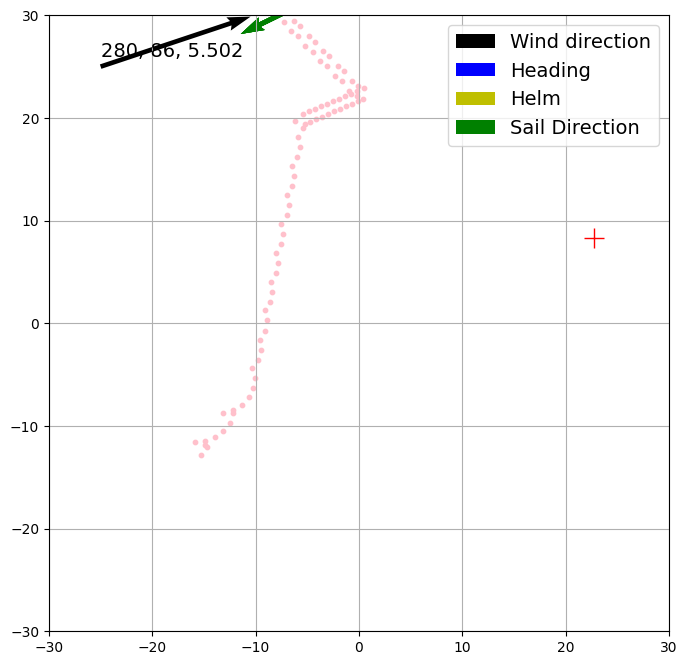

 58%|██████████████████████████████████████████████                                  | 288/500 [00:20<00:12, 16.92it/s]

130


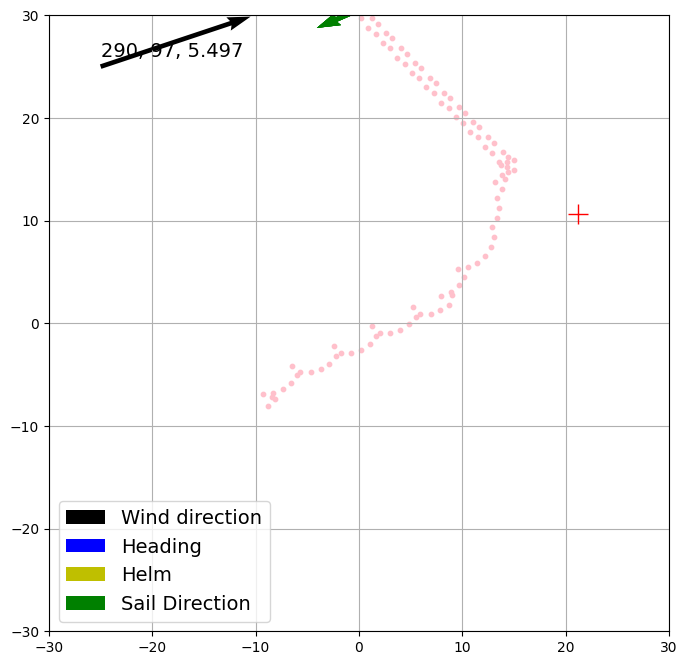

 59%|███████████████████████████████████████████████▌                                | 297/500 [00:20<00:12, 16.75it/s]

132


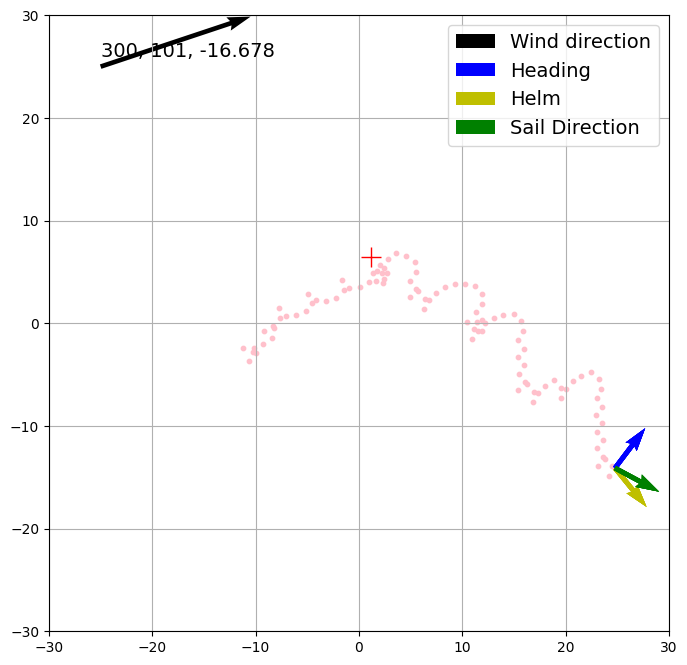

 61%|████████████████████████████████████████████████▉                               | 306/500 [00:21<00:12, 15.76it/s]

137


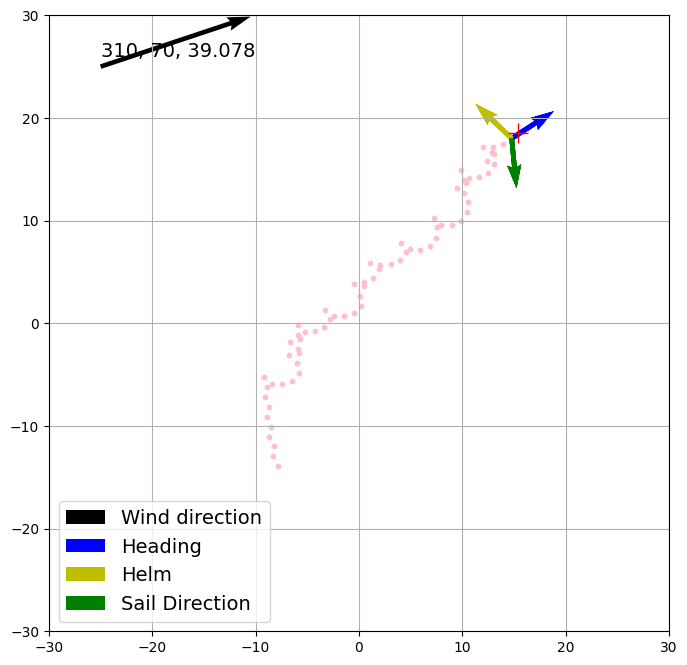

 63%|██████████████████████████████████████████████████▍                             | 315/500 [00:22<00:11, 15.89it/s]

140


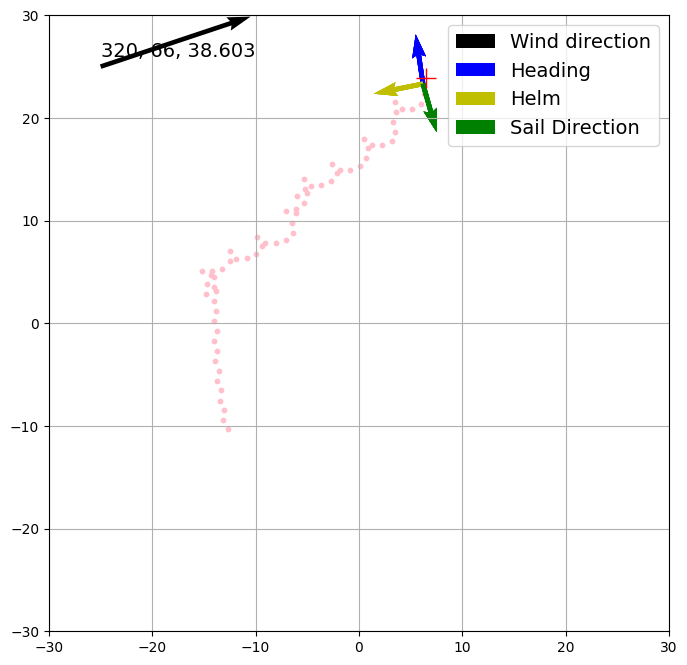

 65%|███████████████████████████████████████████████████▊                            | 324/500 [00:22<00:11, 15.71it/s]

144


 66%|████████████████████████████████████████████████████▋                           | 329/500 [00:22<00:08, 19.56it/s]

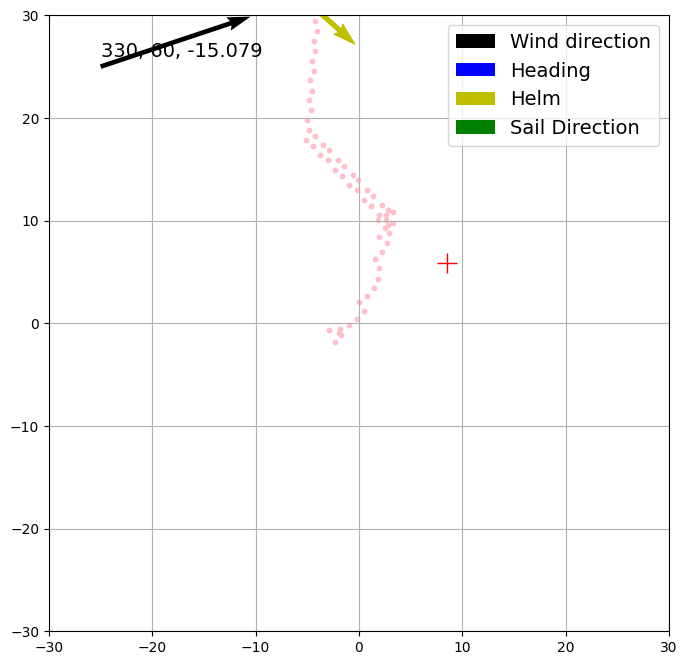

 68%|██████████████████████████████████████████████████████                          | 338/500 [00:24<00:14, 10.82it/s]

149


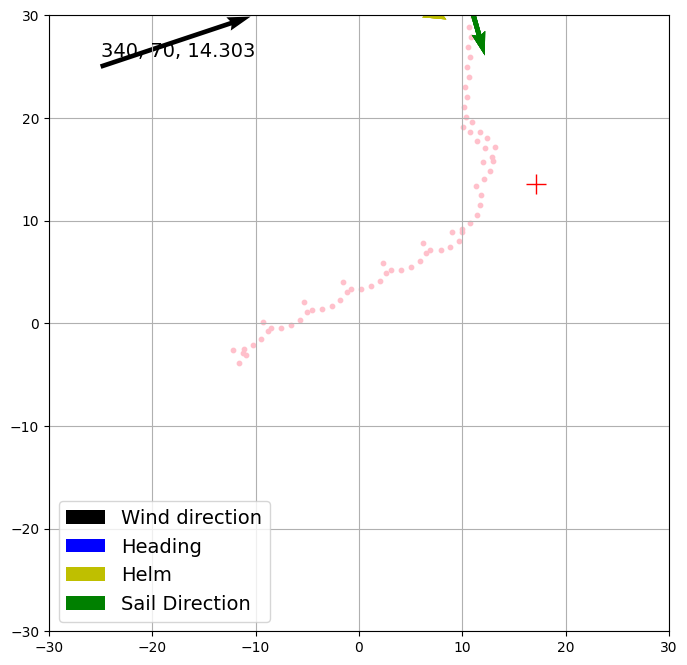

 69%|███████████████████████████████████████████████████████▎                        | 346/500 [00:24<00:12, 12.69it/s]

152


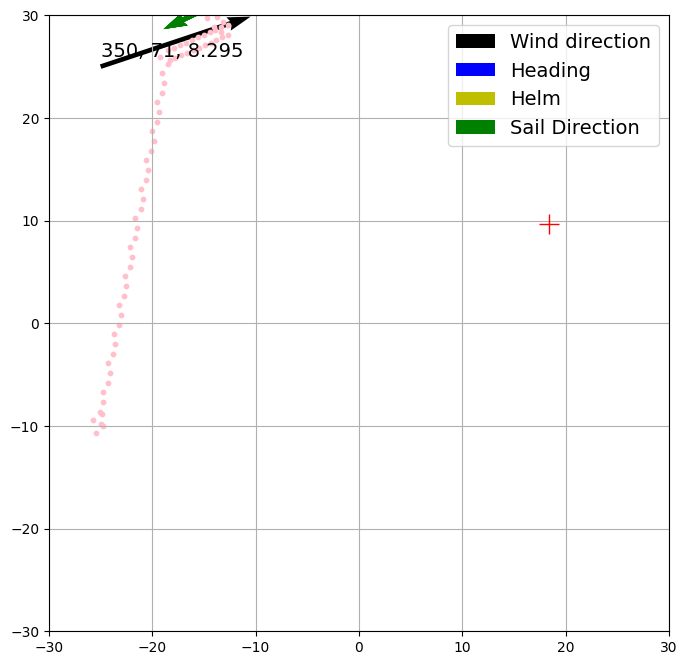

 71%|████████████████████████████████████████████████████████▊                       | 355/500 [00:25<00:10, 14.21it/s]

159


 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [00:25<00:08, 17.07it/s]

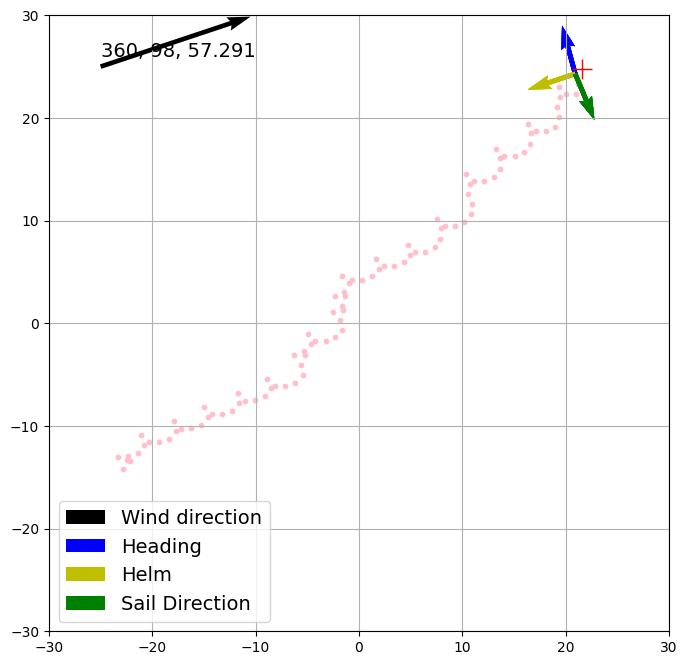

 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [00:26<00:09, 13.87it/s]

163


 74%|███████████████████████████████████████████████████████████                     | 369/500 [00:26<00:08, 15.40it/s]

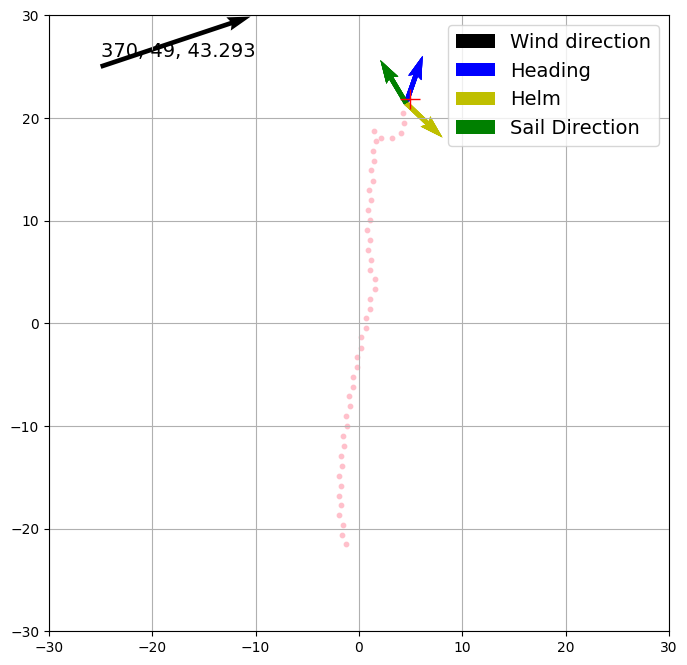

 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [00:27<00:09, 13.73it/s]

168


 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [00:27<00:07, 15.92it/s]

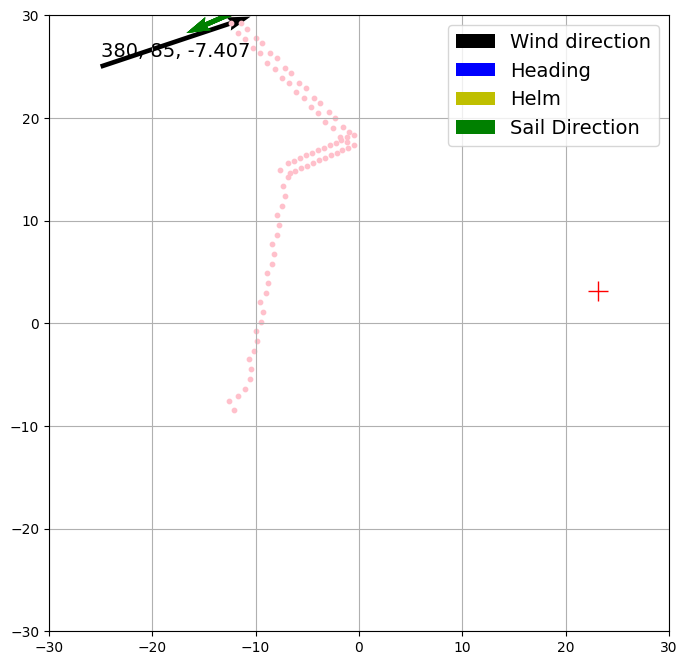

 78%|██████████████████████████████████████████████████████████████                  | 388/500 [00:27<00:06, 16.70it/s]

172


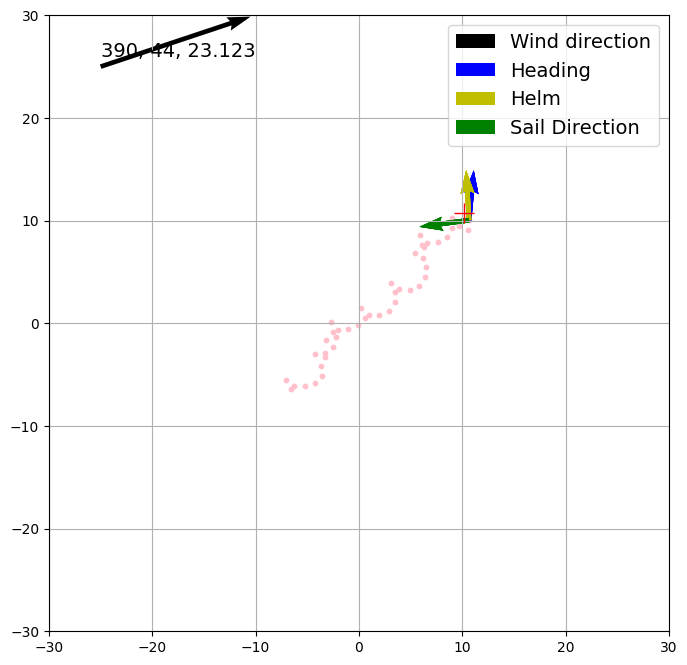

 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [00:28<00:06, 15.16it/s]

178


 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [00:28<00:05, 17.09it/s]

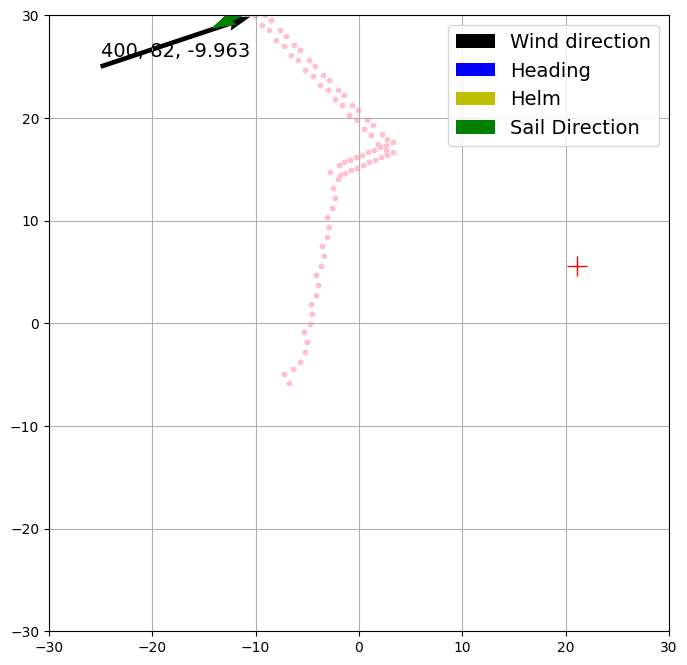

 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [00:29<00:06, 14.67it/s]

182


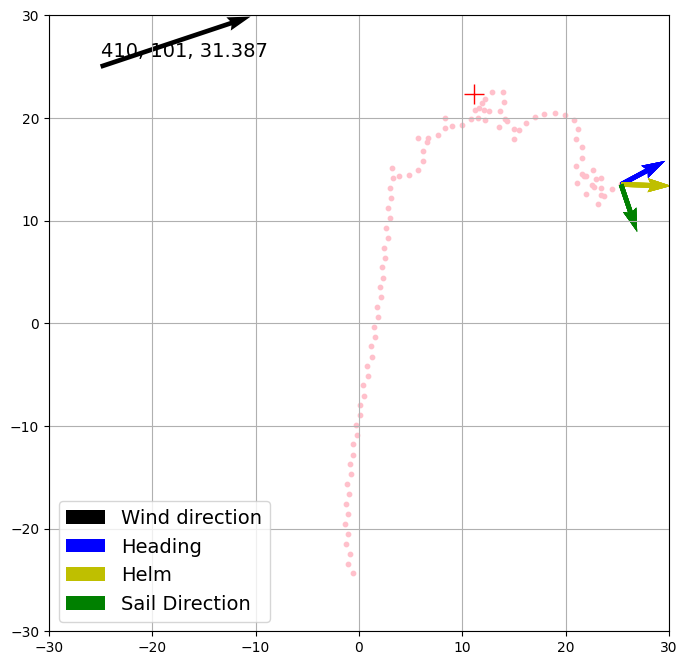

 83%|██████████████████████████████████████████████████████████████████▍             | 415/500 [00:29<00:05, 15.06it/s]

185


 84%|███████████████████████████████████████████████████████████████████             | 419/500 [00:30<00:04, 18.04it/s]

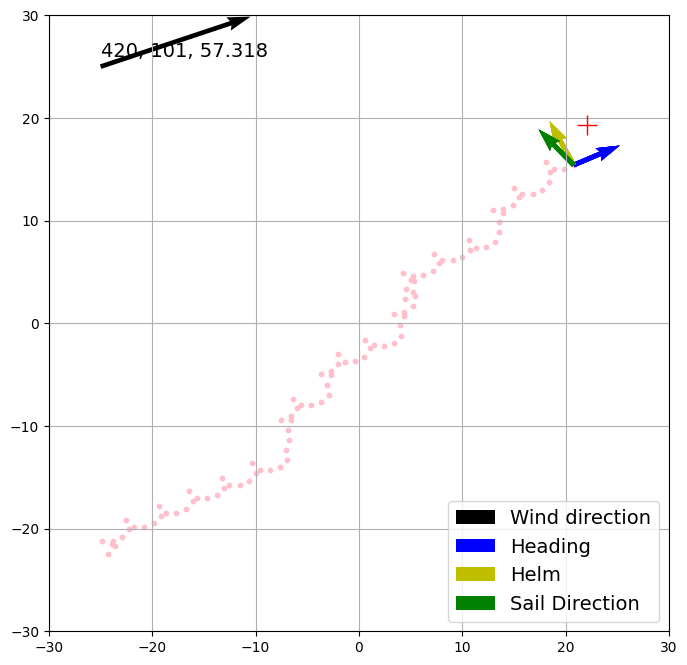

 85%|████████████████████████████████████████████████████████████████████▎           | 427/500 [00:30<00:04, 15.81it/s]

189


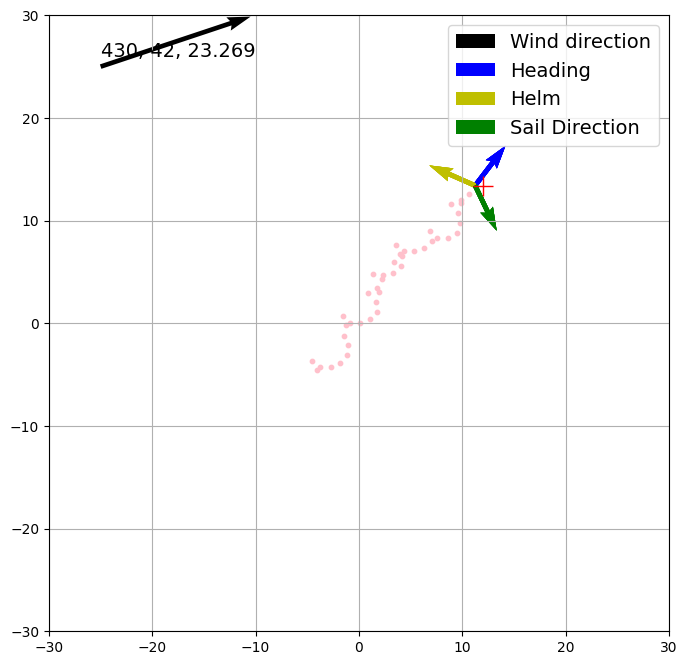

 87%|█████████████████████████████████████████████████████████████████████▌          | 435/500 [00:31<00:04, 15.66it/s]

195


 88%|██████████████████████████████████████████████████████████████████████▏         | 439/500 [00:31<00:03, 18.81it/s]

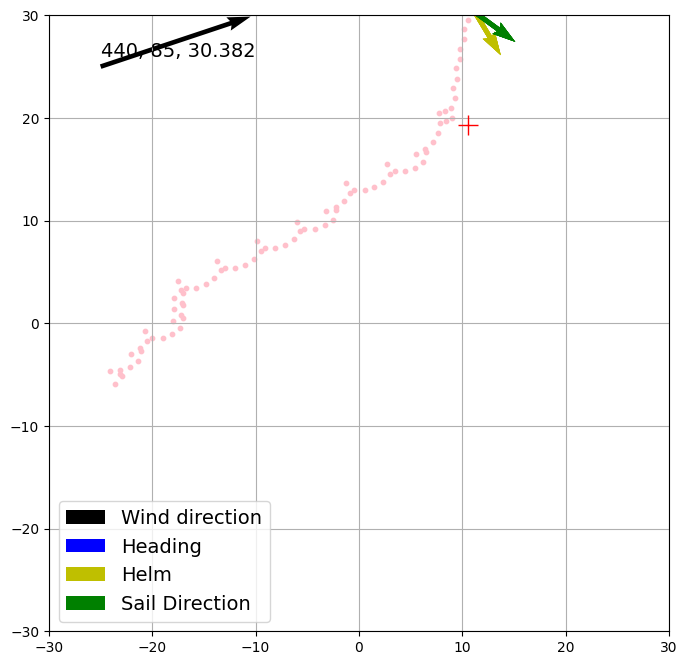

 90%|███████████████████████████████████████████████████████████████████████▋        | 448/500 [00:32<00:03, 17.00it/s]

200


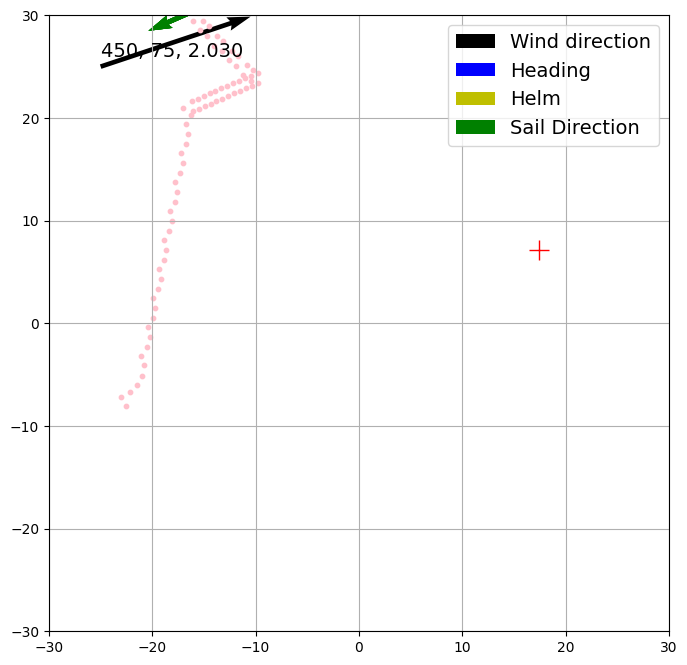

 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [00:32<00:02, 15.74it/s]

204


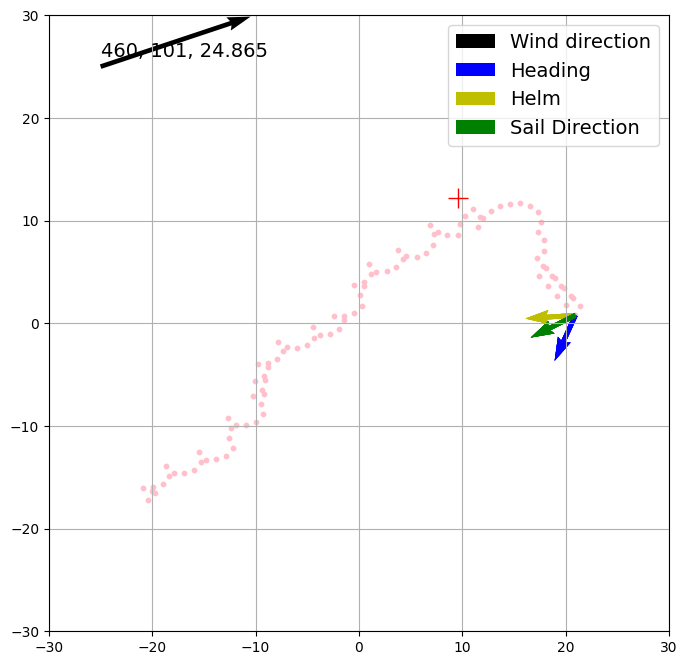

 93%|██████████████████████████████████████████████████████████████████████████▌     | 466/500 [00:33<00:02, 16.80it/s]

209


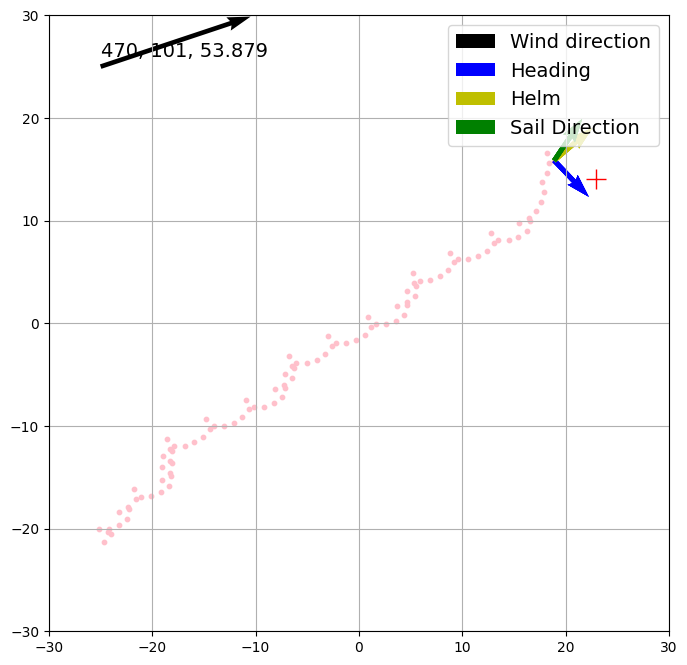

 95%|████████████████████████████████████████████████████████████████████████████    | 475/500 [00:34<00:01, 16.17it/s]

215


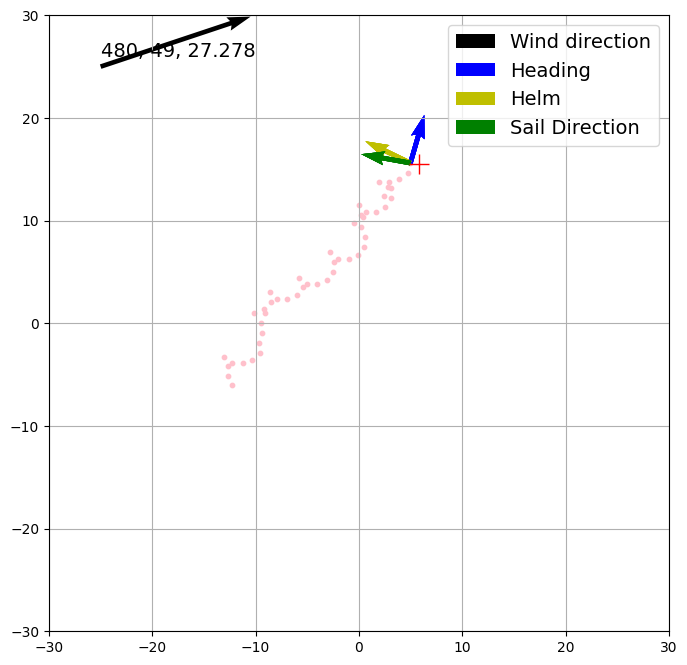

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 485/500 [00:34<00:00, 16.63it/s]

220


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 489/500 [00:34<00:00, 19.17it/s]

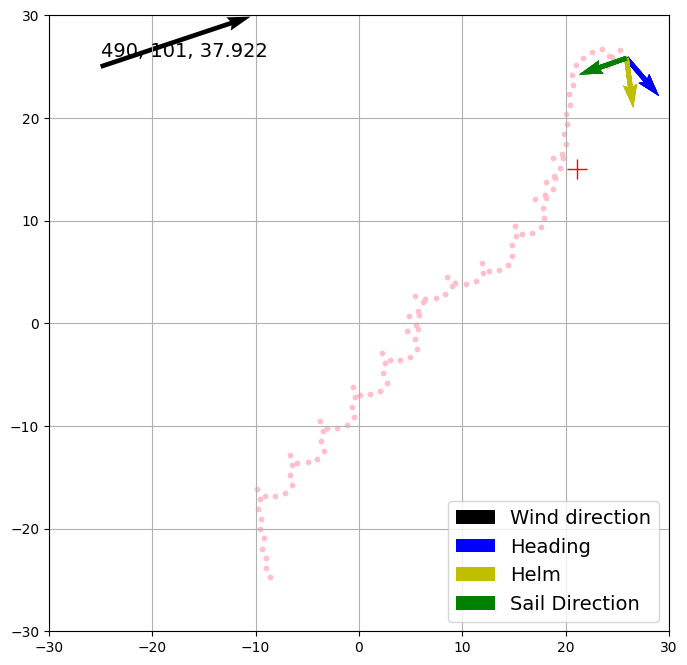

100%|███████████████████████████████████████████████████████████████████████████████▋| 498/500 [00:35<00:00, 17.22it/s]

224


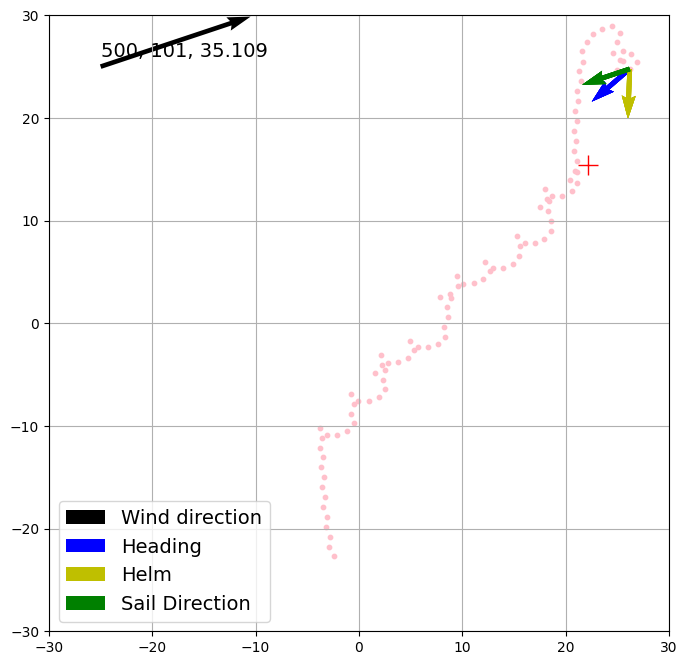

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.88it/s]

229


In [331]:
num_episodes = 500
animation = 10
env.acc = 0
accuracies = []
for i in tqdm(range(1, num_episodes + 1)):
    # epsilons.append(epsilon)
    state, info = env.reset()
    done = False
    while not done:

        action = np.unravel_index(np.argmax((Q[state, :])), (Q[state, :]).shape)
        next_state, reward, done, truncated = env.step(action) #state_action(state, action)
        state = next_state
    accuracies.append(env.acc)
    
    if i%animation == 0: 
        env.render(i)
        print(env.acc)


In [335]:
env.acc/5

45.8

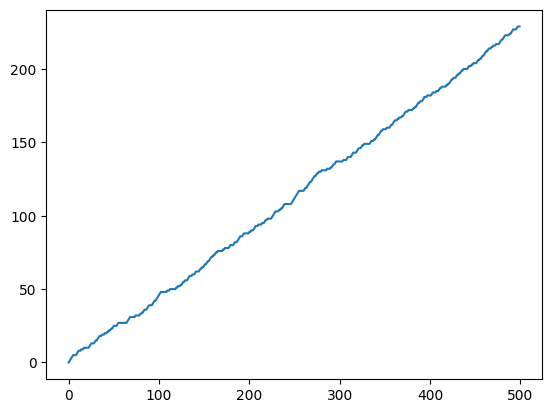

In [333]:
plt.plot(accuracies)